# Notebook CO2 emissions Agri-food Sector


In [41]:
# Install necessary packages 
!pip install scikit-optimize
!pip install shap

# General data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap 
from matplotlib.cm import get_cmap
import seaborn as sns

# Statistics and data transformation
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from scipy.stats import chi2

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # Required for IterativeImputer
from sklearn.impute import IterativeImputer

# PCA
from sklearn.decomposition import PCA

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Model evaluation and validation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.base import clone

# Optimization and hyperparameter tuning
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import DeltaYStopper

# Explainability tools
import shap

## 1. Exploratory Data Analysis

In [4]:
# Loading the data
data = pd.read_csv("Agrofood_co2_emission.csv")
data.info()
data.describe()

# Unique data points of Area
data['Area'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965 entries, 0 to 6964
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Area                             6965 non-null   object 
 1   Year                             6965 non-null   int64  
 2   Savanna fires                    6934 non-null   float64
 3   Forest fires                     6872 non-null   float64
 4   Crop Residues                    5576 non-null   float64
 5   Rice Cultivation                 6965 non-null   float64
 6   Drained organic soils (CO2)      6965 non-null   float64
 7   Pesticides Manufacturing         6965 non-null   float64
 8   Food Transport                   6965 non-null   float64
 9   Forestland                       6472 non-null   float64
 10  Net Forest conversion            6472 non-null   float64
 11  Food Household Consumption       6492 non-null   float64
 12  Food Retail         

236

In [5]:
# Range target variable
range_C02_emissions = data['total_emission'].max() - data['total_emission'].min()
print(range_C02_emissions)

3506997.8046999993


### Distribution Plots

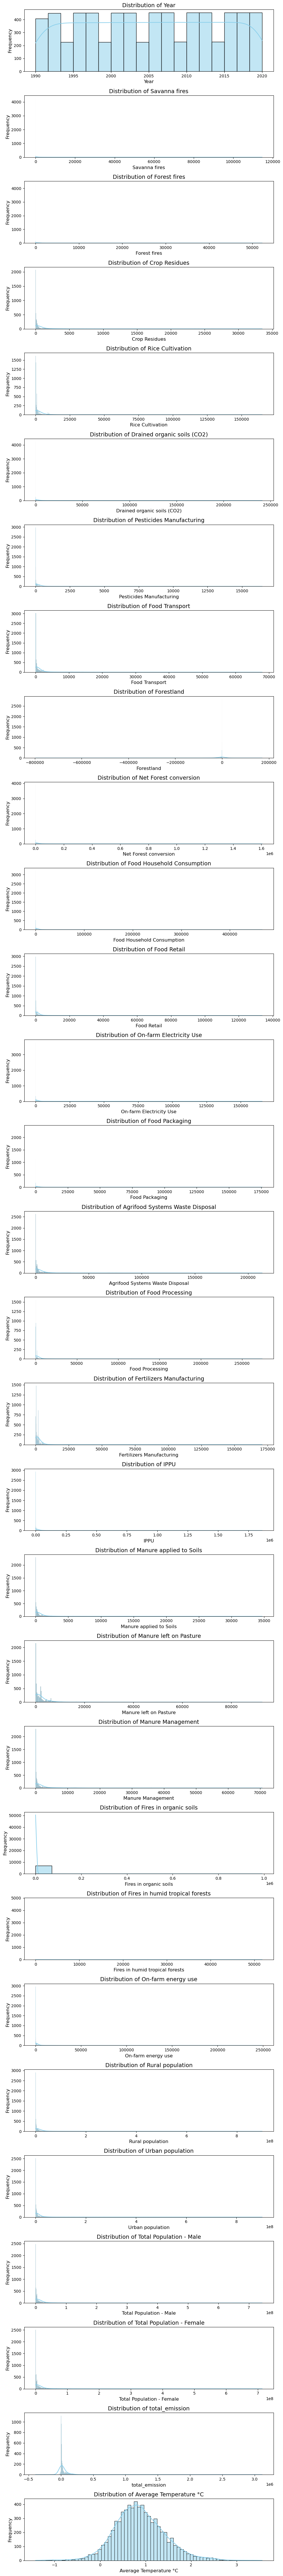

In [6]:
# Distribution numeric features
# Select numeric columns
columns_n = data.select_dtypes(include=['float64', 'int64']).columns
features_n = len(columns_n)

# Set up the figure with subplots for each feature
fig, axes = plt.subplots(features_n, 1, figsize=(10, features_n * 3))

# Plot each feature with histogram and KDE line
for i, col in enumerate(columns_n):
    sns.histplot(data[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

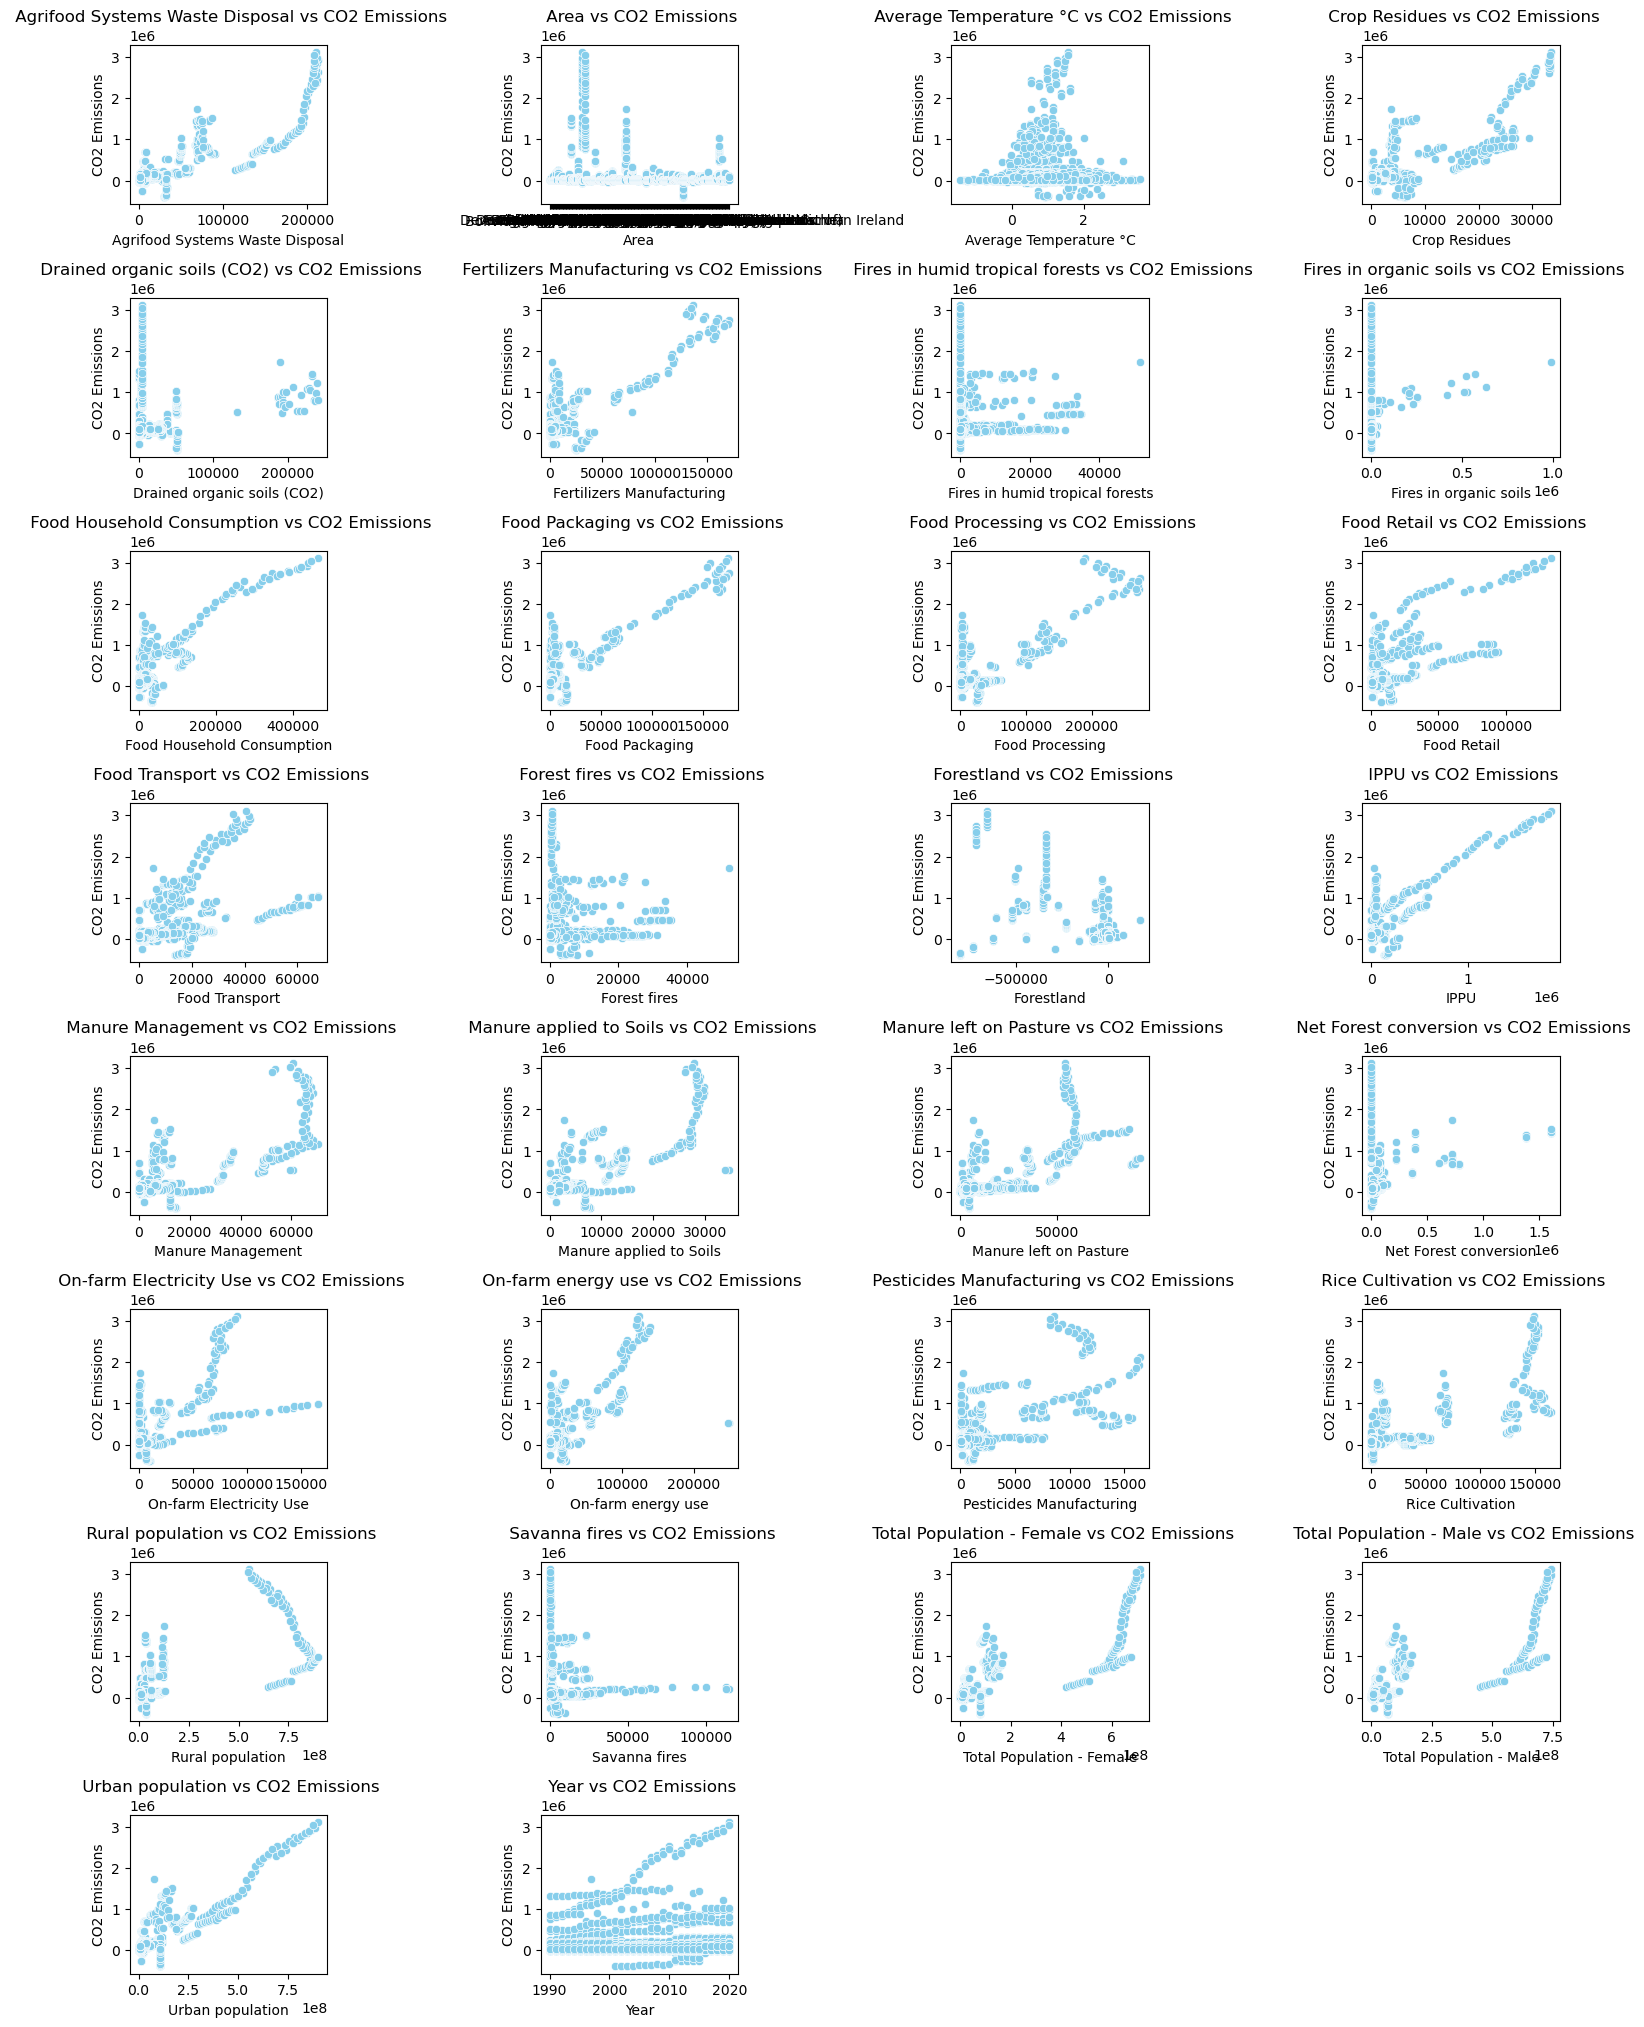

In [7]:
# Features to plot against the Total Emission
independent_vars = data.columns.difference(['total_emission'])

# Scatterplot
plt.figure(figsize=(15, 25))  

for i, var in enumerate(independent_vars):
    plt.subplot(10, 4, i + 1)  
    sns.scatterplot(x=data[var], y=data['total_emission'], color= 'skyblue', marker= 'o')
    plt.title(f' {var} vs CO2 Emissions')
    plt.xlabel(var)
    plt.ylabel('CO2 Emissions')

plt.tight_layout()
plt.show()


In [8]:
# Distribution plot categoric feature 'Area':
distribution_area = data['Area'].value_counts()
print(distribution_area)

Afghanistan                        31
Isle of Man                        31
Montserrat                         31
Morocco                            31
Mozambique                         31
                                   ..
Czechoslovakia                      3
Ethiopia PDR                        3
USSR                                2
Yugoslav SFR                        2
Pacific Islands Trust Territory     1
Name: Area, Length: 236, dtype: int64


In [9]:
# Count unique countries
unique_countries = data['Area'].nunique()

# Count how many areas have exactly 31 values
count_31_values = data['Area'].value_counts()[data['Area'].value_counts() == 31].count()

print(f"Number of unique countries: {unique_countries}")
print(f"Number of areas with exactly 31 observations: {count_31_values}")

Number of unique countries: 236
Number of areas with exactly 31 observations: 194


Category with max observations: Afghanistan (31 observations)



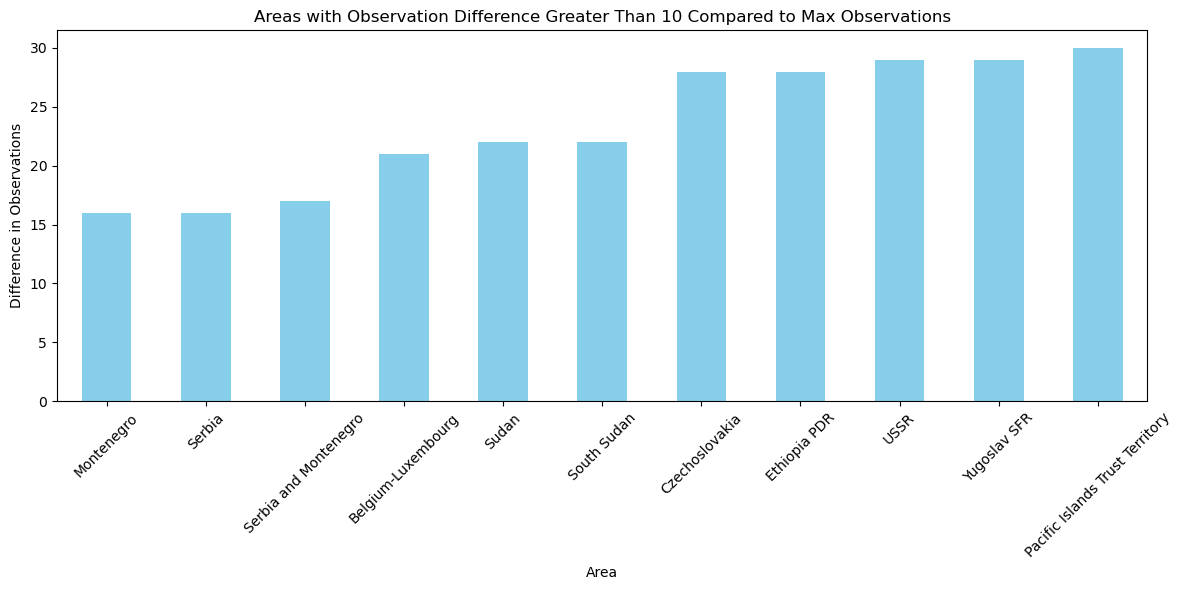

In [10]:
# Class imbalance in 'Area' feature?
# Identify the 'Area' category with the maximum observations
max_category = data['Area'].value_counts().idxmax()
max_category_count = data['Area'].value_counts().max()

print(f"Category with max observations: {max_category} ({max_category_count} observations)\n")
       
# Calculate differences and filter areas with a difference greater than 10
area_counts = data['Area'].value_counts()
diff_counts = area_counts.apply(lambda x: max_category_count - x)
diff_counts = diff_counts[diff_counts > 10]

# Plot the results
plt.figure(figsize=(12, 6))
diff_counts.plot(kind='bar', color='skyblue')
plt.title('Areas with Observation Difference Greater Than 10 Compared to Max Observations')
plt.xlabel('Area')
plt.ylabel('Difference in Observations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Correlation Matrix (Multivariate analysis)

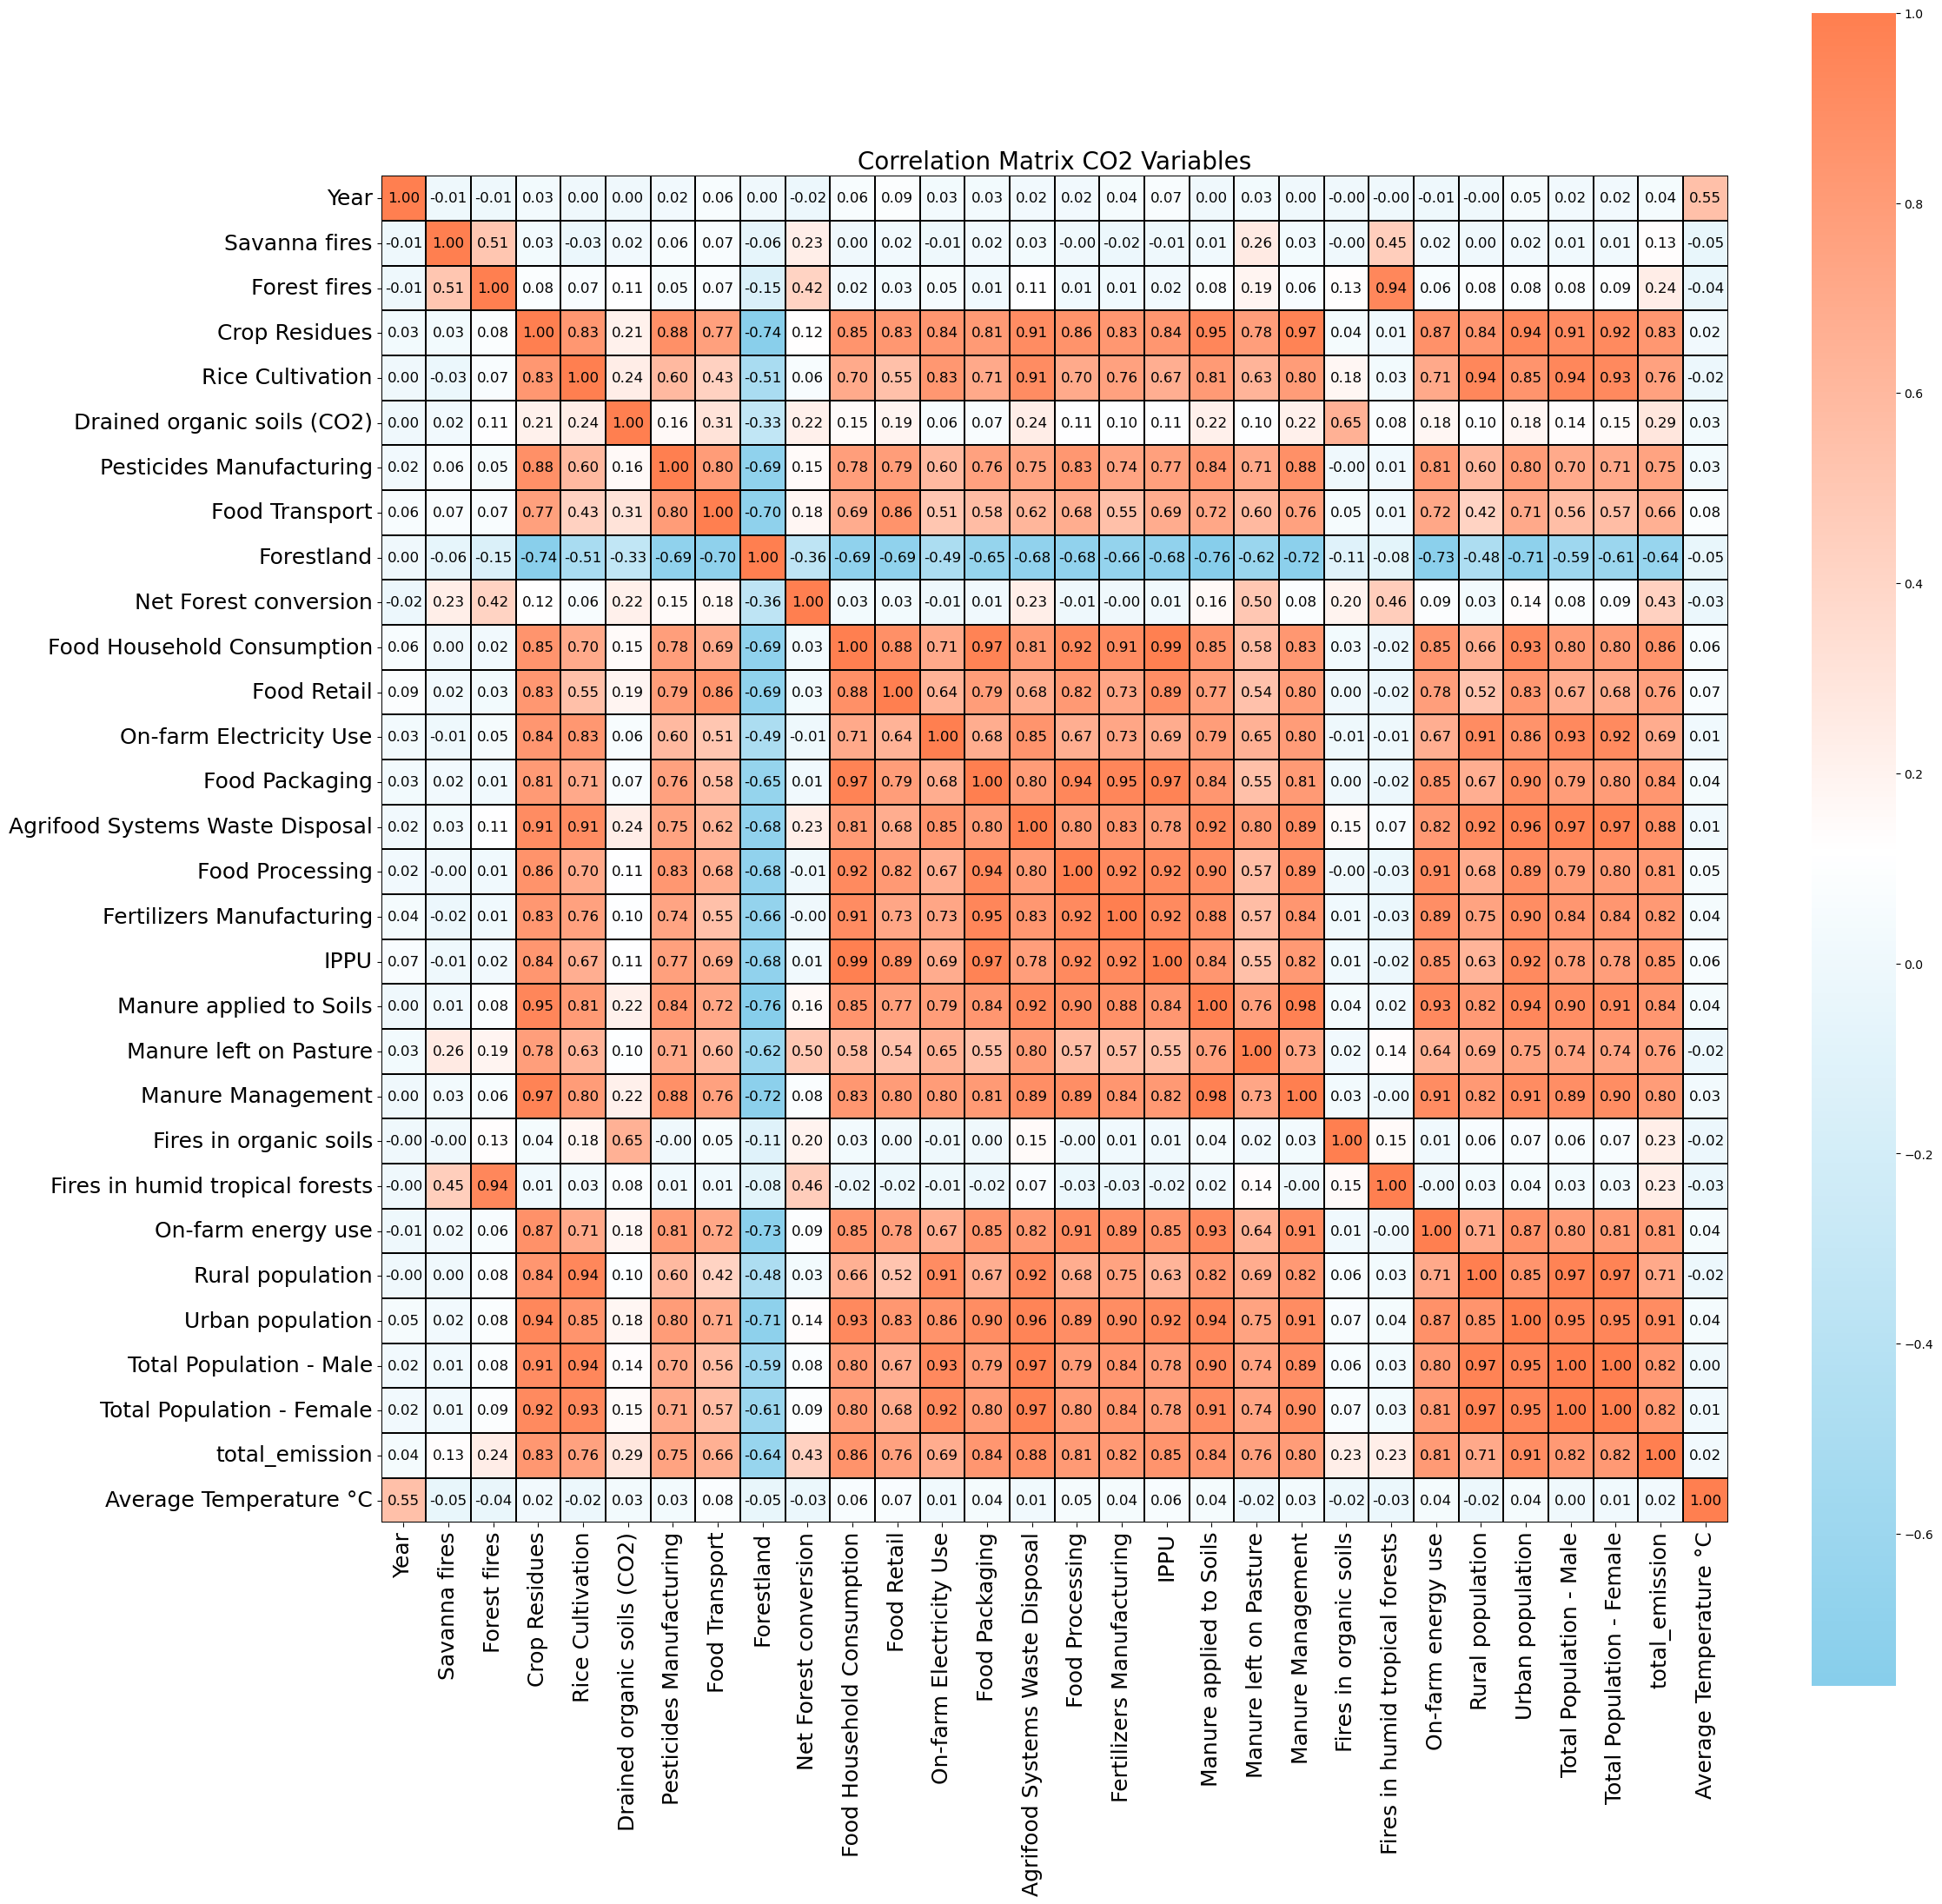

In [11]:
correlation_matrix = data.corr(method = 'pearson',numeric_only= True).round(2)

# Custom colormap
cmap = LinearSegmentedColormap.from_list(
    "Custom", ["#87CEEB", "white", "#FF7F50"]
)

plt.figure(figsize= (25,25))       
sns.heatmap(correlation_matrix.round(2), annot= True, cmap= cmap, fmt= '.2f', linewidths= 0.3,  linecolor='black', square= True, annot_kws={"size": 12, "color": "black"})  

plt.xticks(fontsize=18)  
plt.yticks(fontsize=18)
plt.title("Correlation Matrix CO2 Variables", fontsize = 20)
plt.savefig('Correlation Matrix CO2 Variables', bbox_inches='tight')
plt.show()

In [12]:
# Pearson correlation between total_emission and other features:
total_emission_correlations = correlation_matrix['total_emission']
print(total_emission_correlations)

On_farm_electricity_use = correlation_matrix['On-farm Electricity Use']
print(On_farm_electricity_use)

Year                               0.04
Savanna fires                      0.13
Forest fires                       0.24
Crop Residues                      0.83
Rice Cultivation                   0.76
Drained organic soils (CO2)        0.29
Pesticides Manufacturing           0.75
Food Transport                     0.66
Forestland                        -0.64
Net Forest conversion              0.43
Food Household Consumption         0.86
Food Retail                        0.76
On-farm Electricity Use            0.69
Food Packaging                     0.84
Agrifood Systems Waste Disposal    0.88
Food Processing                    0.81
Fertilizers Manufacturing          0.82
IPPU                               0.85
Manure applied to Soils            0.84
Manure left on Pasture             0.76
Manure Management                  0.80
Fires in organic soils             0.23
Fires in humid tropical forests    0.23
On-farm energy use                 0.81
Rural population                   0.71


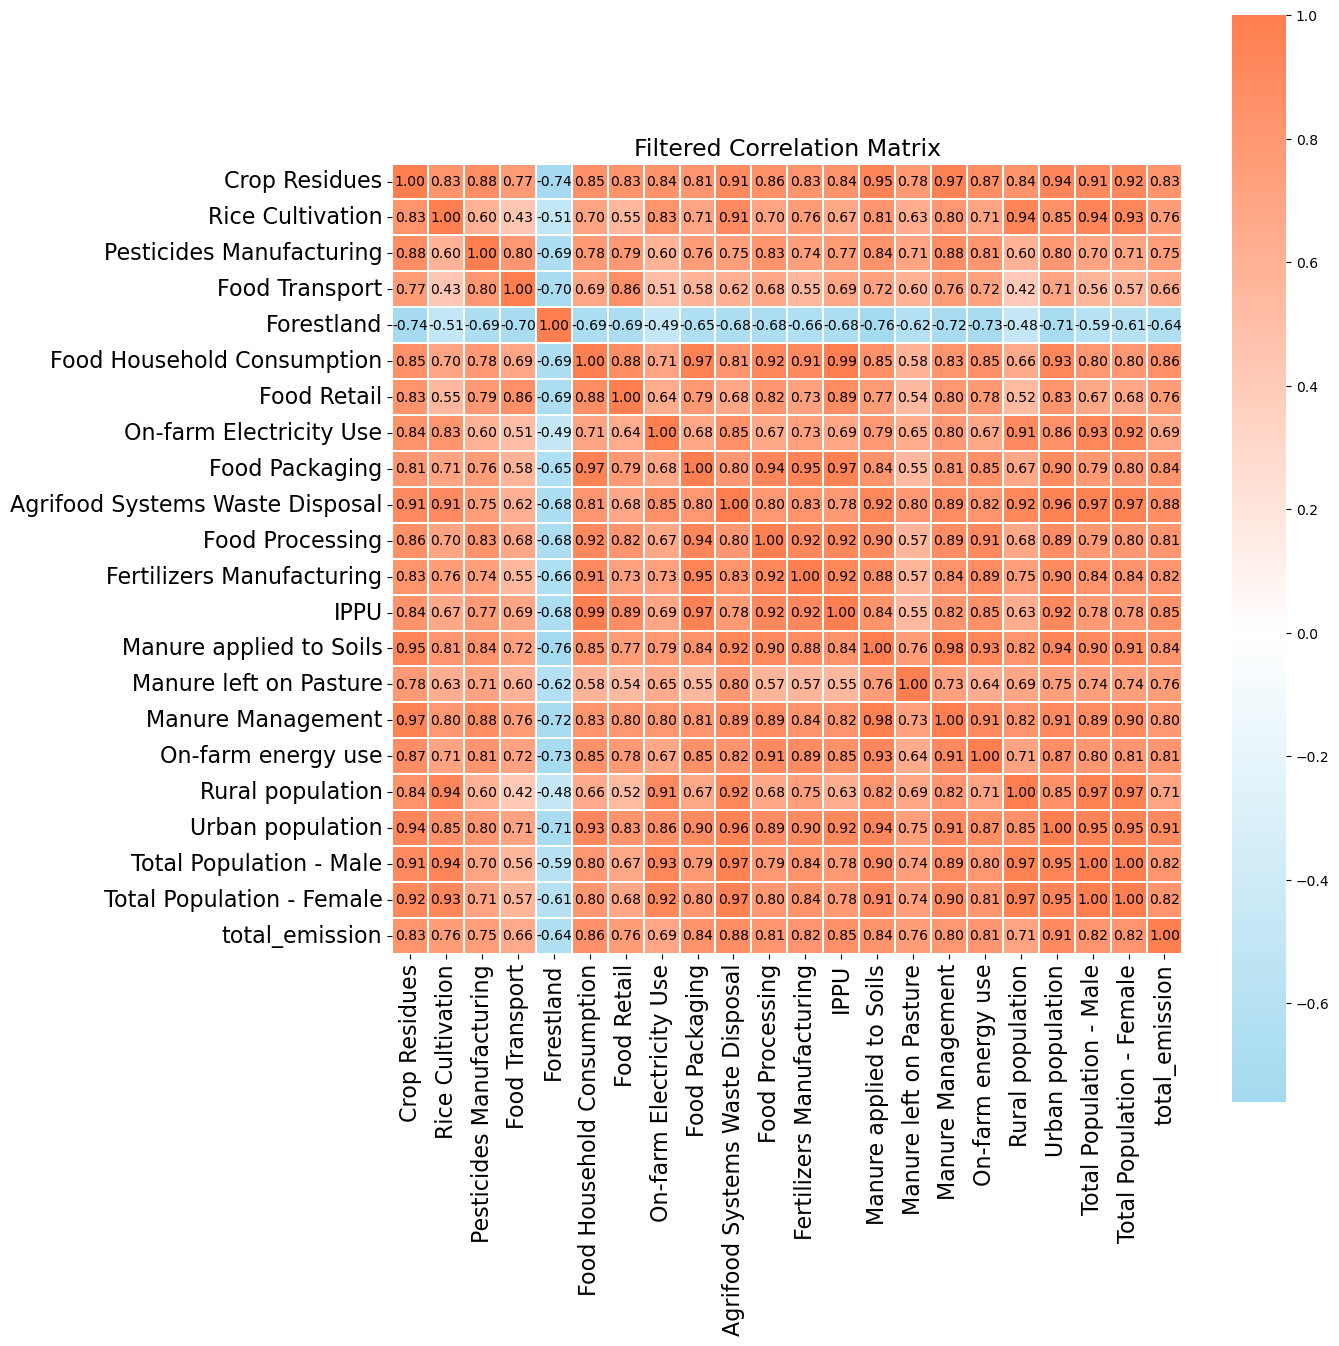

In [13]:
# Filter correlation with total_emission > 0.5 or < -0.5
significant_correlations = total_emission_correlations[
    (total_emission_correlations > 0.5) | (total_emission_correlations < -0.5)
]
selected_features = significant_correlations.index

# Correlatiematrix with selected features
reduced_correlation_matrix = correlation_matrix.loc[selected_features, selected_features]

cmap = LinearSegmentedColormap.from_list(
    "Custom", ["#87CEEB", "white", "#FF7F50"]
)

# Plot the correlation matrix
plt.figure(figsize=(14, 14))  
sns.heatmap(
    reduced_correlation_matrix, 
    annot=True, 
    cmap= cmap,  
    fmt='.2f', 
    linewidths=0.3, 
    square=True, 
    annot_kws={"size": 10,"color": "black"},
    center=0
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Filtered Correlation Matrix", fontsize=17)
plt.tight_layout()
plt.savefig('Reduced_Correlation_Matrix_Reversed.png', dpi=300)  
plt.show()


In [14]:
# Correlation > 0.8
filtered_correlations = total_emission_correlations[total_emission_correlations > 0.8]
print(filtered_correlations)

Crop Residues                      0.83
Food Household Consumption         0.86
Food Packaging                     0.84
Agrifood Systems Waste Disposal    0.88
Food Processing                    0.81
Fertilizers Manufacturing          0.82
IPPU                               0.85
Manure applied to Soils            0.84
On-farm energy use                 0.81
Urban population                   0.91
Total Population - Male            0.82
Total Population - Female          0.82
total_emission                     1.00
Name: total_emission, dtype: float64


### Data Quality Issues

Savanna fires                       0.445083
Forest fires                        1.335248
Crop Residues                      19.942570
Forestland                          7.078248
Net Forest conversion               7.078248
Food Household Consumption          6.791098
IPPU                               10.667624
Manure applied to Soils            13.323762
Manure Management                  13.323762
Fires in humid tropical forests     2.225413
On-farm energy use                 13.725772
dtype: float64


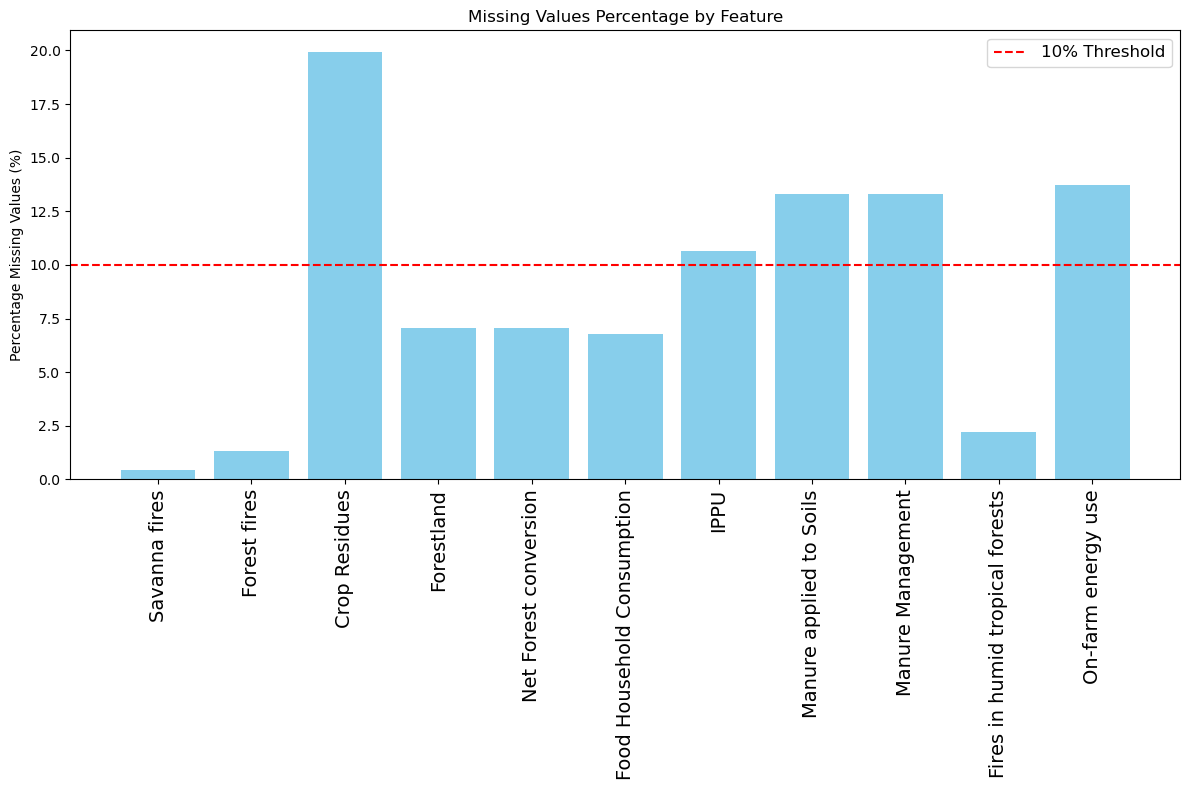

In [15]:
# Missing values within the dataset:
N_missingvalues = data.isnull().sum()
R_missingvalues = data.isnull().mean() * 100

# Which specific features has missing values?
R_missingvalues = R_missingvalues[R_missingvalues > 0]

print(R_missingvalues)

# Plot % of missing values
plt.figure(figsize=(12, 8))
plt.bar(R_missingvalues.index, R_missingvalues.values, color='skyblue')
plt.axhline(y=10, color='r', linestyle='--', label='10% Threshold')
plt.ylabel('Percentage Missing Values (%)')
plt.title('Missing Values Percentage by Feature')
plt.xticks(rotation= 90, fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout() 
plt.savefig('missingvalues_plot.png')
plt.show()

In [16]:
#MCAR
# Calculate observed missing patterns
missing_patterns = data.isnull().astype(int)
pattern_counts = missing_patterns.value_counts()

# Create expected frequencies assuming MCAR
expected_counts = np.full_like(pattern_counts, fill_value=np.mean(pattern_counts))

# Chi-square statistic
chi_square_stat = np.sum((pattern_counts - expected_counts)**2 / expected_counts)

# Degrees of freedom
df = len(pattern_counts) - 1

# P-value
p_value = chi2.sf(chi_square_stat, df)

# Results
print(f"Chi-square Statistic: {chi_square_stat}, p-value: {p_value}")
if p_value > 0.05:
    print("Data is MCAR (Missing Completely At Random).")
else:
    print("Data is not MCAR.")

Chi-square Statistic: 105703.45212765958, p-value: 0.0
Data is not MCAR.


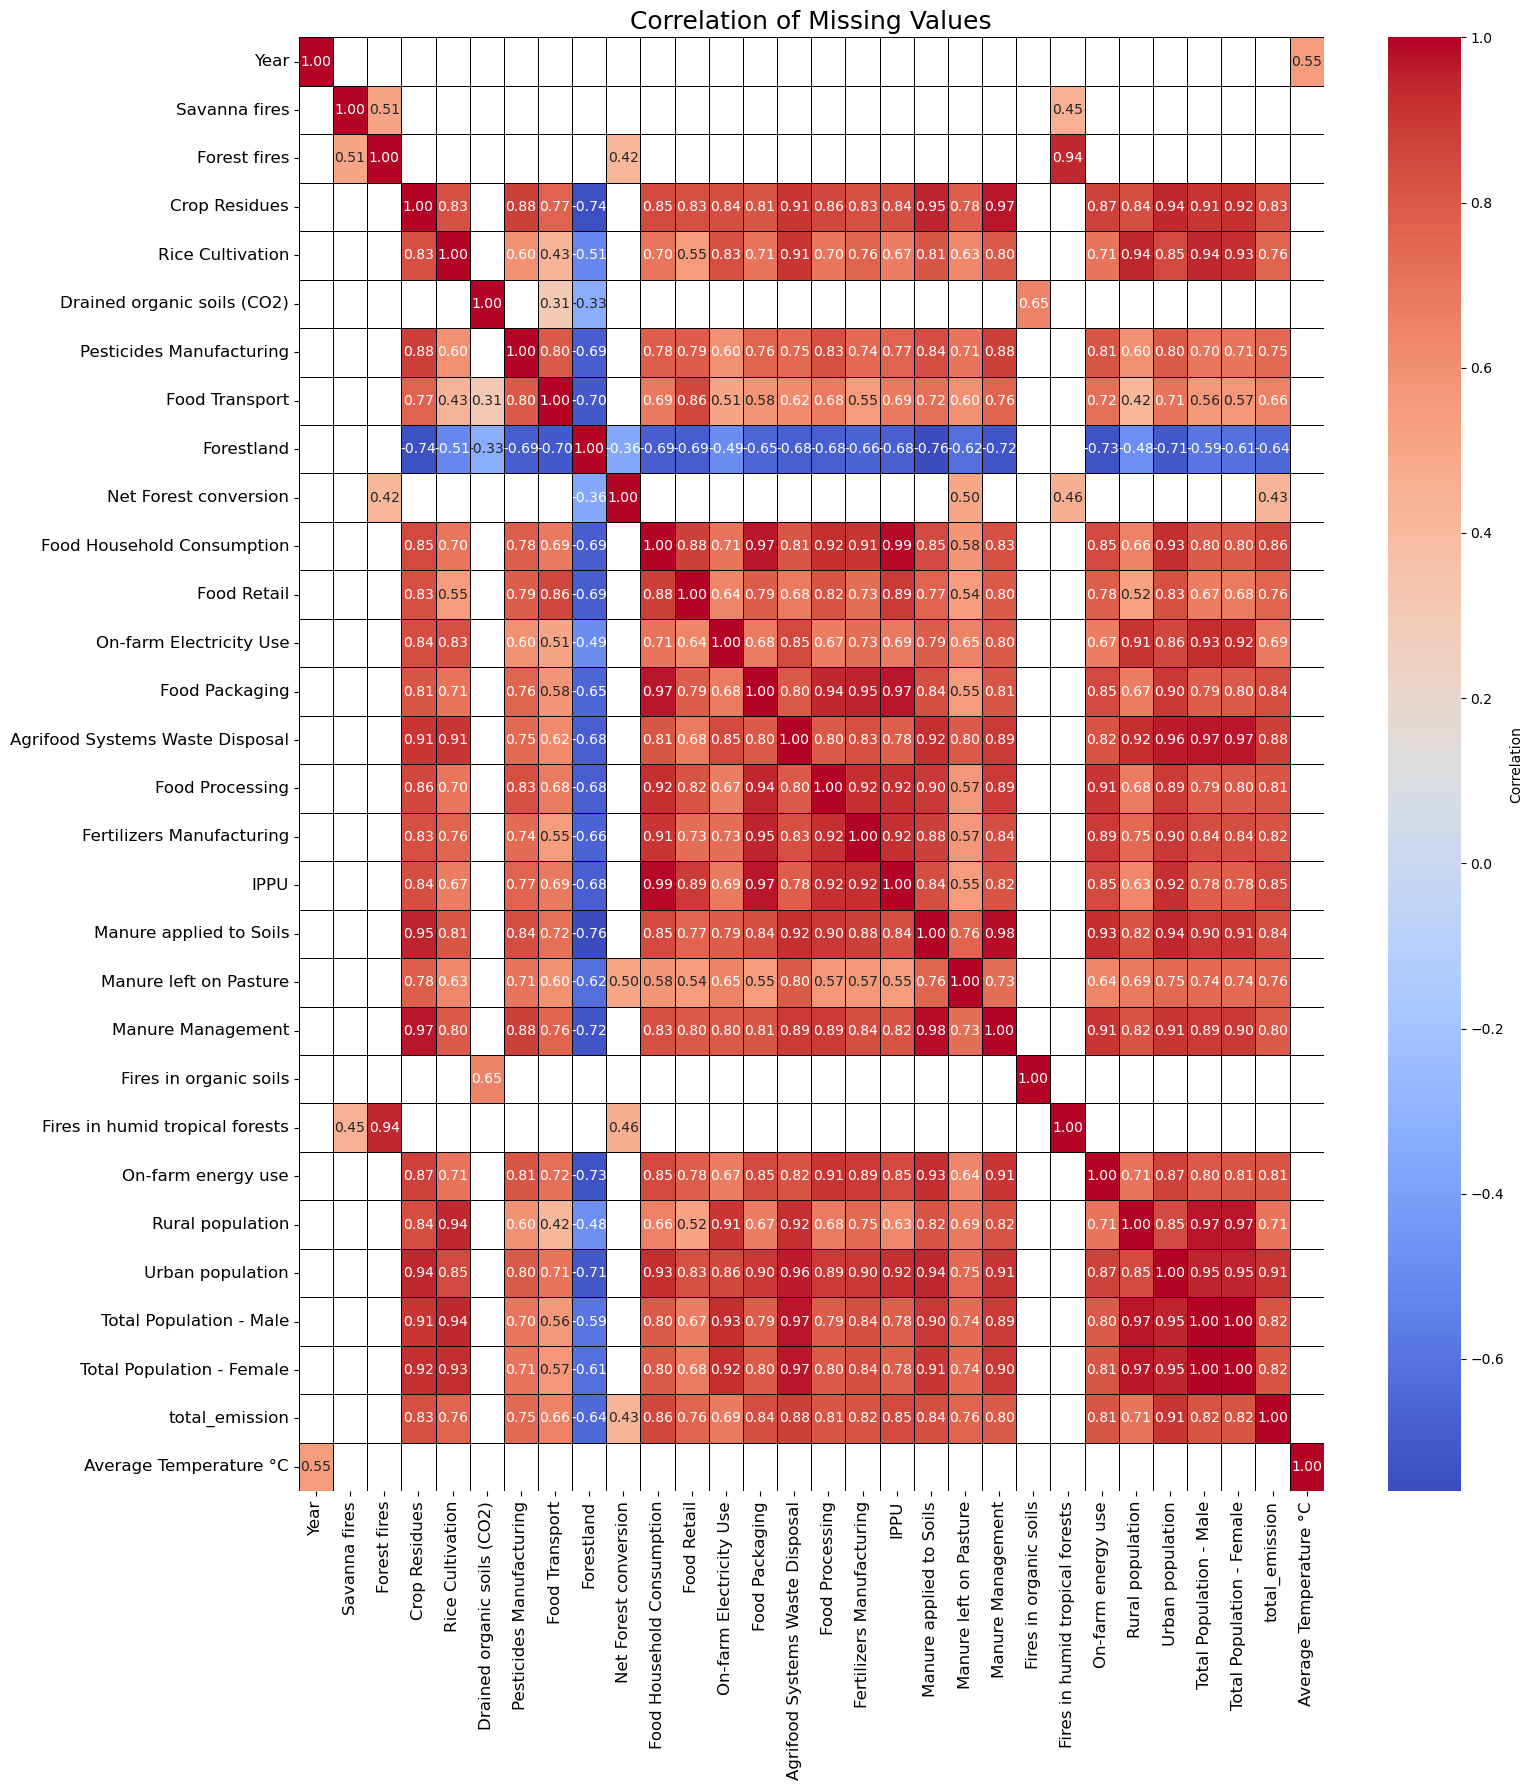

In [17]:
# MAR
# Calculate correlation matrix for missingness
plt.figure(figsize=(16, 18)) 
mask = correlation_matrix.abs() < 0.3  # Mask correlations below 0.3
sns.heatmap(
    correlation_matrix, 
    mask=mask,  
    annot=True, 
    fmt=".2f",  
    cmap='coolwarm', 
    linewidths=0.5,
    linecolor='black',
    cbar_kws={'label': 'Correlation'},  # Label for color bar
    annot_kws={"size": 10}  
)
plt.title('Correlation of Missing Values', fontsize=18)
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('missing_values_correlation_improved.png')  
plt.show()

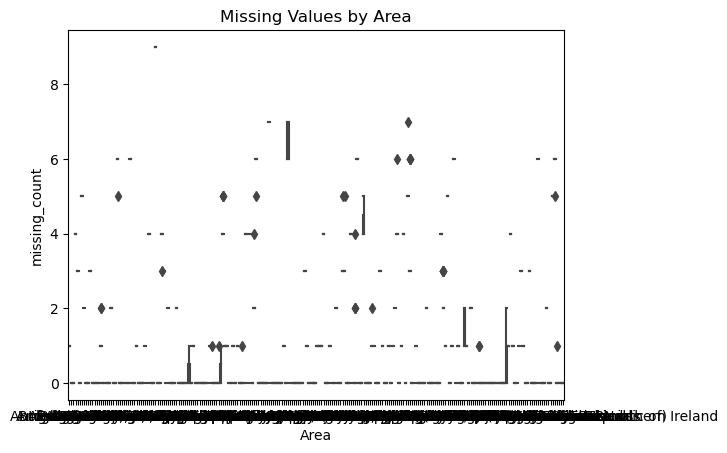

In [18]:
# Copy of the data
data_with_missing = data.copy()

# Add 'missing_count' to the data:
data_with_missing['missing_count'] = data_with_missing.isnull().sum(axis=1)

# Boxplot
sns.boxplot(x='Area', y='missing_count', data=data_with_missing)
plt.title('Missing Values by Area')
plt.savefig('missing_values_by_area.png')
plt.show()

Summary of rows with missing 'Crop Residues':
              Year  Savanna fires  Forest fires  Crop Residues  \
count  1389.000000    1358.000000   1296.000000            0.0   
mean   2005.036717       0.020329      0.031347            NaN   
std       8.923592       0.137496      0.258851            NaN   
min    1990.000000       0.000000      0.000000            NaN   
25%    1997.000000       0.000000      0.000000            NaN   
50%    2005.000000       0.000000      0.000000            NaN   
75%    2013.000000       0.000000      0.000000            NaN   
max    2020.000000       1.972700      5.694800            NaN   

       Rice Cultivation  Drained organic soils (CO2)  \
count       1389.000000                  1389.000000   
mean        2569.868421                   123.637992   
std         2705.272154                   815.513699   
min            0.000000                     0.000000   
25%          921.664109                     0.000000   
50%         1639.724833

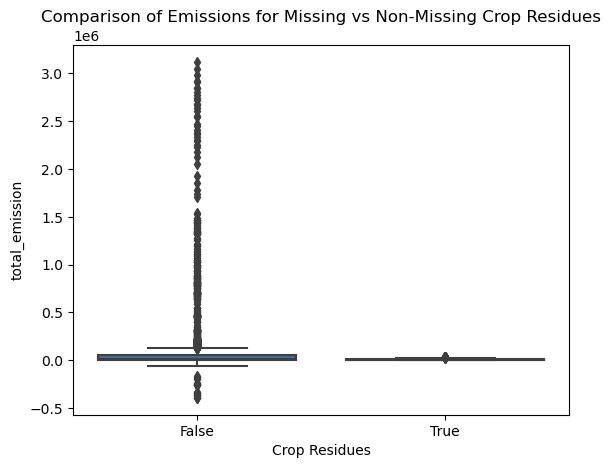

In [19]:
# MNAR
# Analyze rows with missing values
missing_rows = data[data['Crop Residues'].isnull()]
non_missing_rows = data[~data['Crop Residues'].isnull()]

# Summary statistics
print("Summary of rows with missing 'Crop Residues':")
print(missing_rows.describe())

print("Summary of rows without missing 'Crop Residues':")
print(non_missing_rows.describe())

sns.boxplot(x=data['Crop Residues'].isnull(), y=data['total_emission'])
plt.title('Comparison of Emissions for Missing vs Non-Missing Crop Residues')
plt.savefig('comparisonmissingornonmissingcrop.png')  
plt.show()

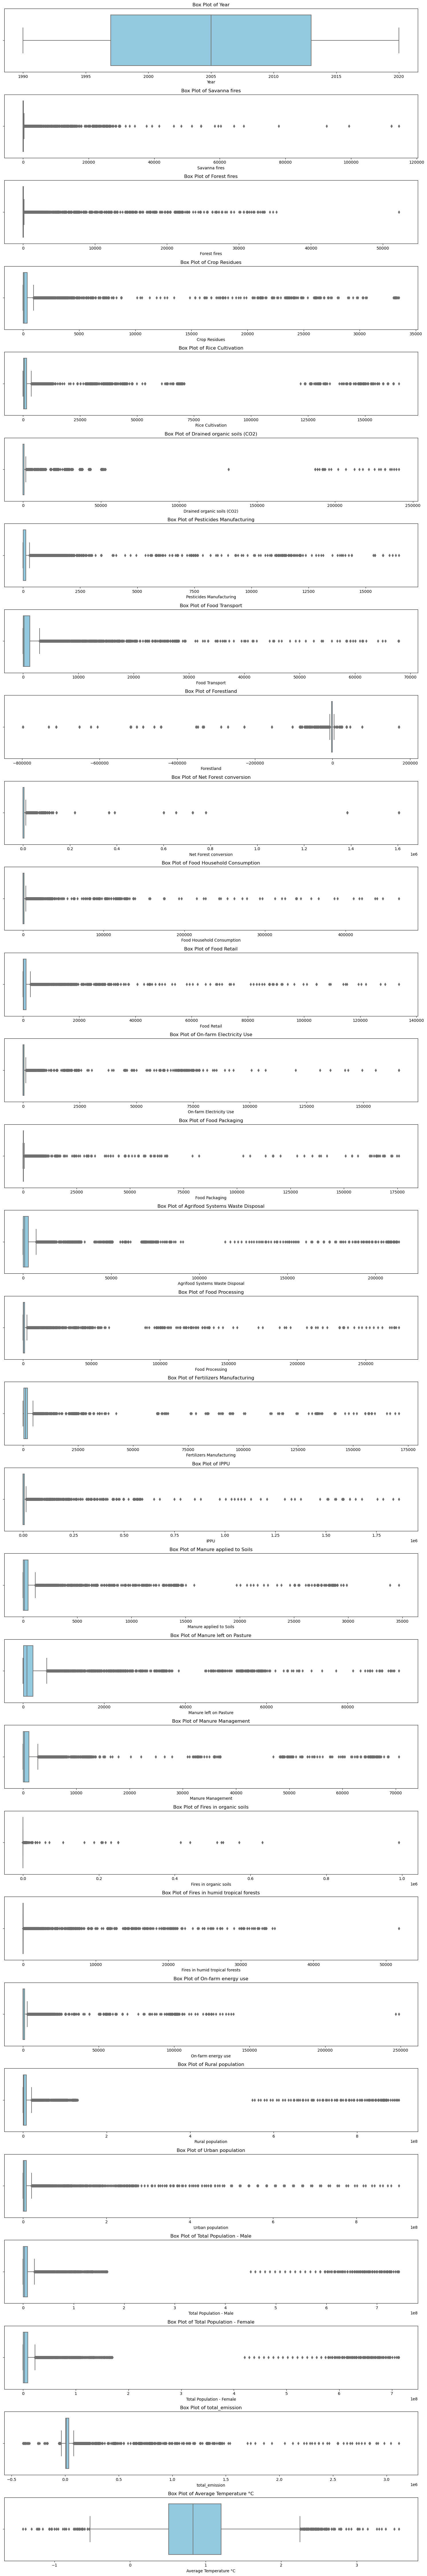

In [20]:
# Outliers within the dataset:
# Plot box plots for all numeric features
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(15, len(numeric_features) * 3))

for i, feature in enumerate(numeric_features):
    plt.subplot(len(numeric_features), 1, i + 1)
    sns.boxplot(x=data[feature], color='skyblue')
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()

In [21]:
# Function to calculate the Median Absolute Deviation (MAD)
def mad(series):
    return np.median(np.abs(series - np.median(series)))

# Calculate MAD for all numeric features
median = data[numeric_features].median()
mad_values = data[numeric_features].apply(mad)

# Calculate MAD scores for each value
mad_scores = data[numeric_features].sub(median).abs().div(mad_values)

# Identify rows where any feature has a MAD score above a threshold (e.g., > 3)
outliers = (mad_scores > 3).any(axis=1)
outliers_data = data[outliers]

# Count outliers per feature (MAD threshold > 3)
outlier_counts = (mad_scores > 3).sum()

# Count percentage per feature
outlier_percentages = (outlier_counts / len(data)) * 100

# Dataframe with outlier counts and percentages
outlier_stats_df = pd.DataFrame({
    'Feature': outlier_counts.index,
    'Outlier_Count': outlier_counts.values,
    'Outlier_Percentage': outlier_percentages.values
})

# Features with outliers
outlier_stats_df = outlier_stats_df[outlier_stats_df['Outlier_Count'] > 0]

print(outlier_stats_df)

# Drained organic soils outlier? --> according to literature range till 100+ MtCO₂ per year

max_drained= data["Drained organic soils (CO2)"].max()
upper_limit = np.percentile(data["Drained organic soils (CO2)"], 99)
print("max drained =",  max_drained)
print("Upper limit of winsorizing =",  upper_limit)


                            Feature  Outlier_Count  Outlier_Percentage
4                  Rice Cultivation           1513           21.722900
5       Drained organic soils (CO2)           3112           44.680546
6          Pesticides Manufacturing           2368           33.998564
7                    Food Transport           2133           30.624551
11                      Food Retail           2152           30.897344
12          On-farm Electricity Use           2768           39.741565
13                   Food Packaging           1820           26.130653
14  Agrifood Systems Waste Disposal           1587           22.785355
15                  Food Processing           1915           27.494616
16        Fertilizers Manufacturing           1008           14.472362
19           Manure left on Pasture           1336           19.181622
21           Fires in organic soils            309            4.436468
24                 Rural population           2040           29.289304
25    

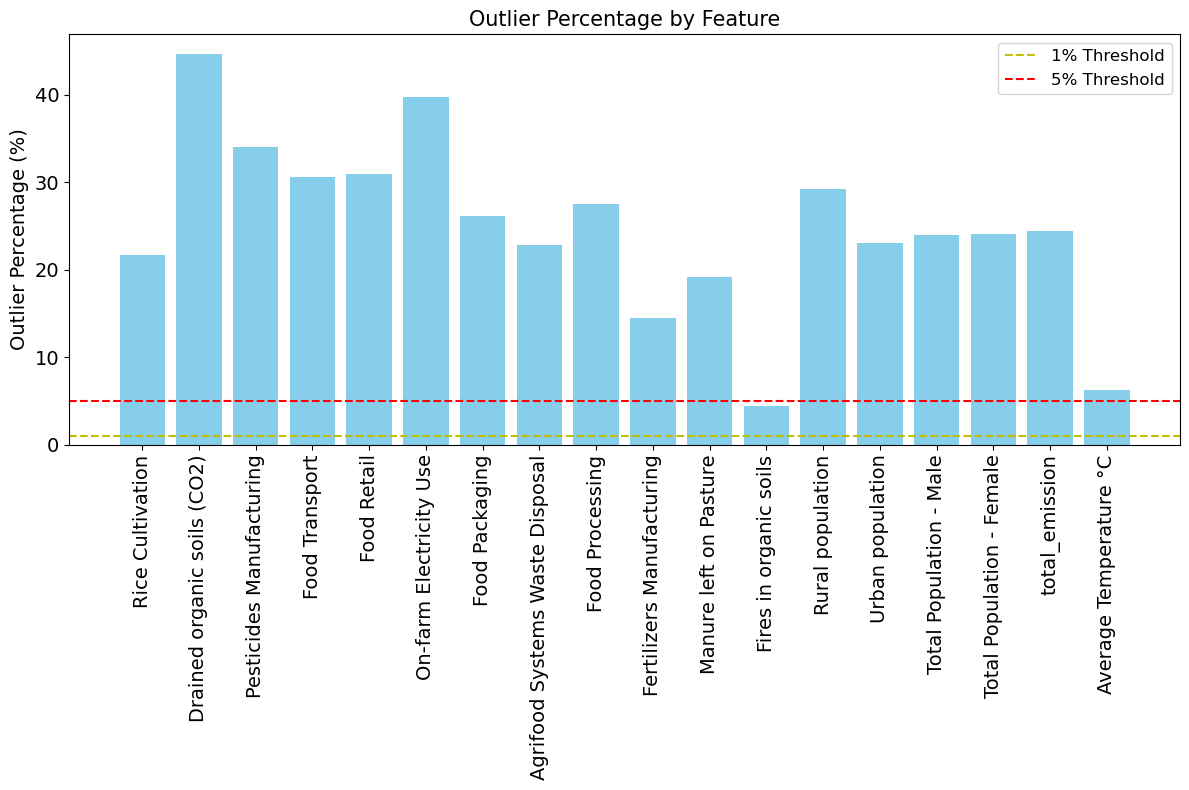

In [22]:
# Plot % of outliers
plt.figure(figsize=(12, 8))
plt.bar(outlier_stats_df['Feature'], outlier_stats_df['Outlier_Percentage'], color='skyblue')
plt.axhline(y=1, color='y', linestyle='--', label='1% Threshold')
plt.axhline(y=5, color='r', linestyle='--', label='5% Threshold')

# Add labels and title
plt.ylabel('Outlier Percentage (%)', fontsize=14)
plt.title('Outlier Percentage by Feature', fontsize=15)

# Adjust x-tick labels
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14) 

# Add legend
plt.legend(fontsize=12)

# Adjust layout and save
plt.tight_layout()  
plt.savefig('outlier_plot2.png', dpi=300)
plt.show()


In [23]:
def outlier_summary(data):
    summary = {}

    # Select numeric columns
    numeric_data = data.select_dtypes(include=[np.number])

    for column in numeric_data.columns:
        max_value = numeric_data[column].max()
        upper_limit = np.percentile(numeric_data[column], 99)  # 99 percentil as with winsorizing 
        outlier_count = (numeric_data[column] > upper_limit).sum()  

        summary[column] = {
            'Max Value': max_value,
            '99th Percentile': upper_limit,
            'Outlier_Count': outlier_count
        }

    # Display the information in a dataframe
    outlier_stats_df = pd.DataFrame(summary).T
    outlier_stats_df = outlier_stats_df[outlier_stats_df['Outlier_Count'] > 0]

    return outlier_stats_df

# Print the information
outlier_info = outlier_summary(data)
print(outlier_info)

                                    Max Value  99th Percentile  Outlier_Count
Rice Cultivation                 1.649153e+05     1.303634e+05           70.0
Drained organic soils (CO2)      2.410251e+05     5.056473e+04           70.0
Pesticides Manufacturing         1.645900e+04     9.925520e+03           70.0
Food Transport                   6.794576e+04     2.701232e+04           70.0
Food Retail                      1.337841e+05     3.356190e+04           70.0
On-farm Electricity Use          1.656763e+05     6.099916e+04           70.0
Food Packaging                   1.757413e+05     3.526082e+04           70.0
Agrifood Systems Waste Disposal  2.132897e+05     1.491733e+05           70.0
Food Processing                  2.742535e+05     1.041166e+05           70.0
Fertilizers Manufacturing        1.708264e+05     3.525254e+04           70.0
Manure left on Pasture           9.263076e+04     5.542681e+04           70.0
Fires in organic soils           9.917175e+05     4.012263e+03  

## 2. Data Preprocessing

### Handeling missing values & outliers

In [24]:
# Creating a copy of the data
data_2 = data.copy()

# Handling missing values based on percentage
# 1. Mean/Median Imputation for missing values 
low_missing_features = R_missingvalues[R_missingvalues <= 10].index

for feature in low_missing_features:
    if feature in outlier_stats_df[outlier_stats_df['Outlier_Percentage'] > 1]['Feature'].values:
        # Median Imputation for skewed data or >1% outliers
        imputer = SimpleImputer(strategy='median')
    else:
        # Mean Imputation for non-skewed data
        imputer = SimpleImputer(strategy='mean')
    data_2[feature] = imputer.fit_transform(data_2[[feature]])

# 2. MICE with PMM for missing values > 10%
high_missing_features = R_missingvalues[R_missingvalues > 10].index

# Applying Multiple Imputation by Chained Equations (MICE) using Predictive Mean Matching (PMM)
mice_imputer = IterativeImputer(max_iter=10, random_state=0, sample_posterior=True)
data_2[high_missing_features] = mice_imputer.fit_transform(data_2[high_missing_features])

# Handling Outliers with Winsorizing
# Apply winsorizing for features with more than 1% outliers
for feature in outlier_stats_df[outlier_stats_df['Outlier_Percentage'] > 1]['Feature']:
    data_2[feature] = winsorize(data_2[feature], limits=[0.01, 0.01])

# Data Check
data_2.isnull().sum()

Area                               0
Year                               0
Savanna fires                      0
Forest fires                       0
Crop Residues                      0
Rice Cultivation                   0
Drained organic soils (CO2)        0
Pesticides Manufacturing           0
Food Transport                     0
Forestland                         0
Net Forest conversion              0
Food Household Consumption         0
Food Retail                        0
On-farm Electricity Use            0
Food Packaging                     0
Agrifood Systems Waste Disposal    0
Food Processing                    0
Fertilizers Manufacturing          0
IPPU                               0
Manure applied to Soils            0
Manure left on Pasture             0
Manure Management                  0
Fires in organic soils             0
Fires in humid tropical forests    0
On-farm energy use                 0
Rural population                   0
Urban population                   0
T

### Encoding categorical variables, diving deeper in the feature 'Area'

In [25]:
# Encoding categorical variables? --> Area
# Creating a copy of data_2 to work on 
data_3 = data_2.copy()

# Label encoding
label_encoder = LabelEncoder()
data_3['Area'] = label_encoder.fit_transform(data_3['Area'])

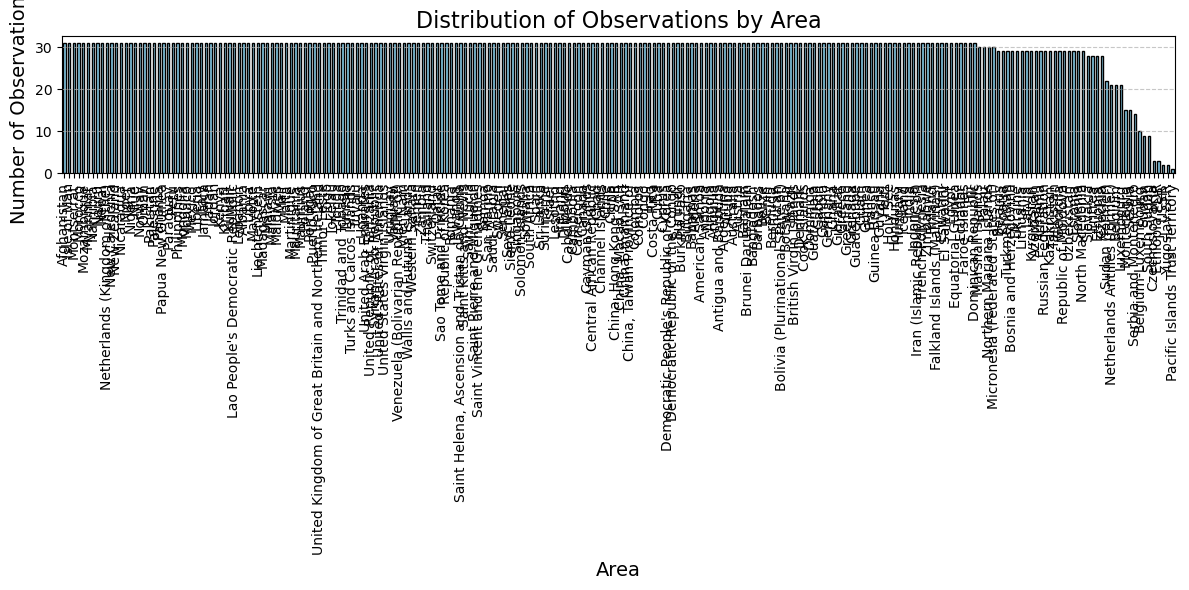

In [26]:
def plot_area_distribution(data):
    # Count the occurrences of each category in the 'Area' feature
    distribution_area = data['Area'].value_counts()

    # Plot the distribution
    plt.figure(figsize=(12, 6))
    distribution_area.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Distribution of Observations by Area', fontsize=16)
    plt.xlabel('Area', fontsize=14)
    plt.ylabel('Number of Observations', fontsize=14)
    plt.xticks(rotation=90, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()
    
plot_area_distribution(data) 

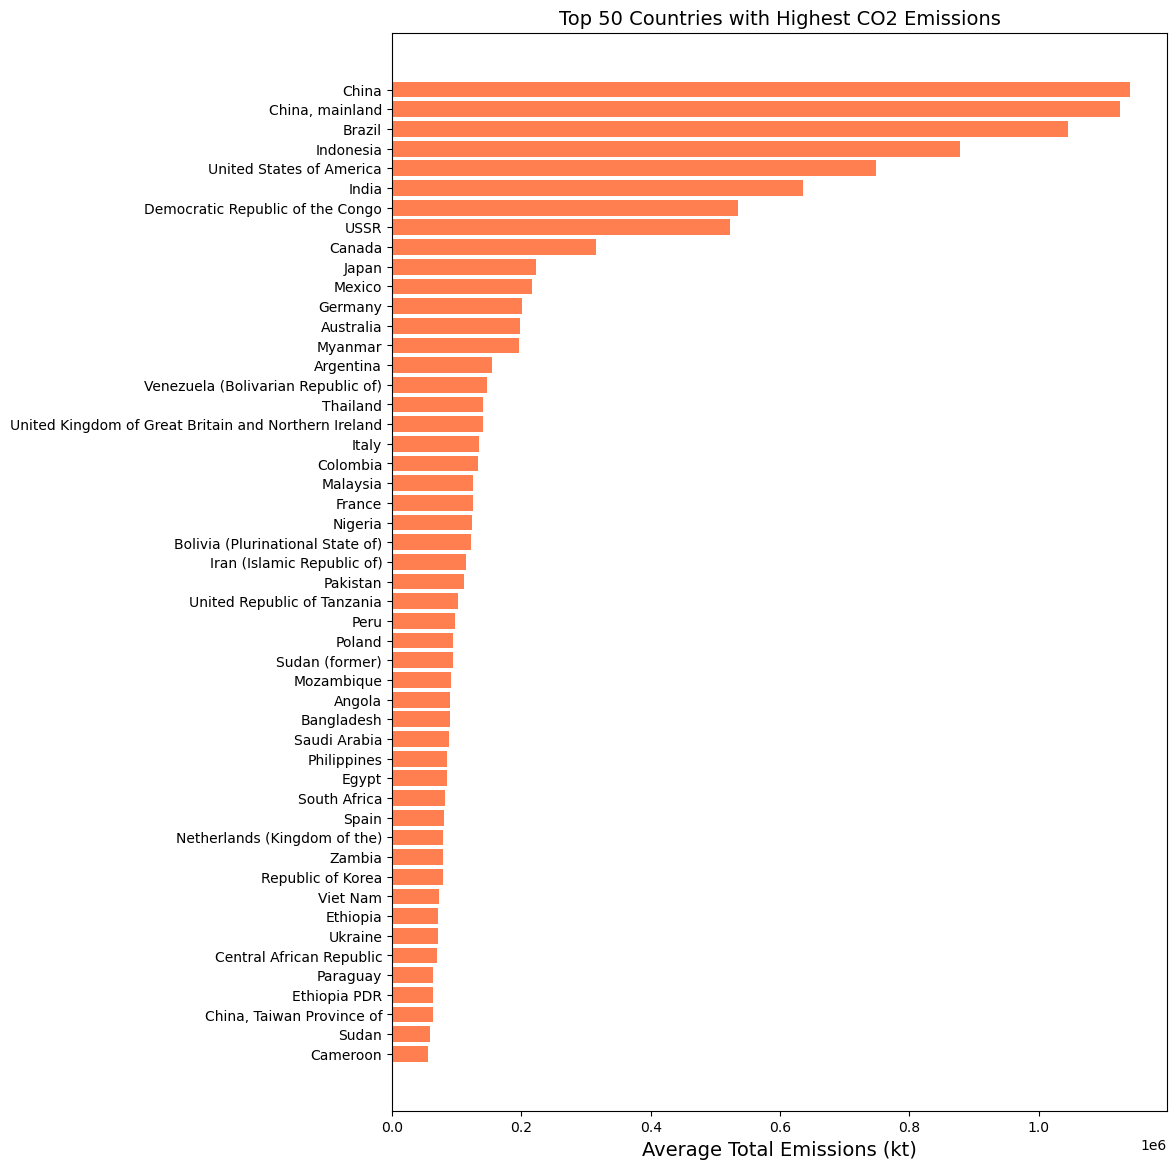

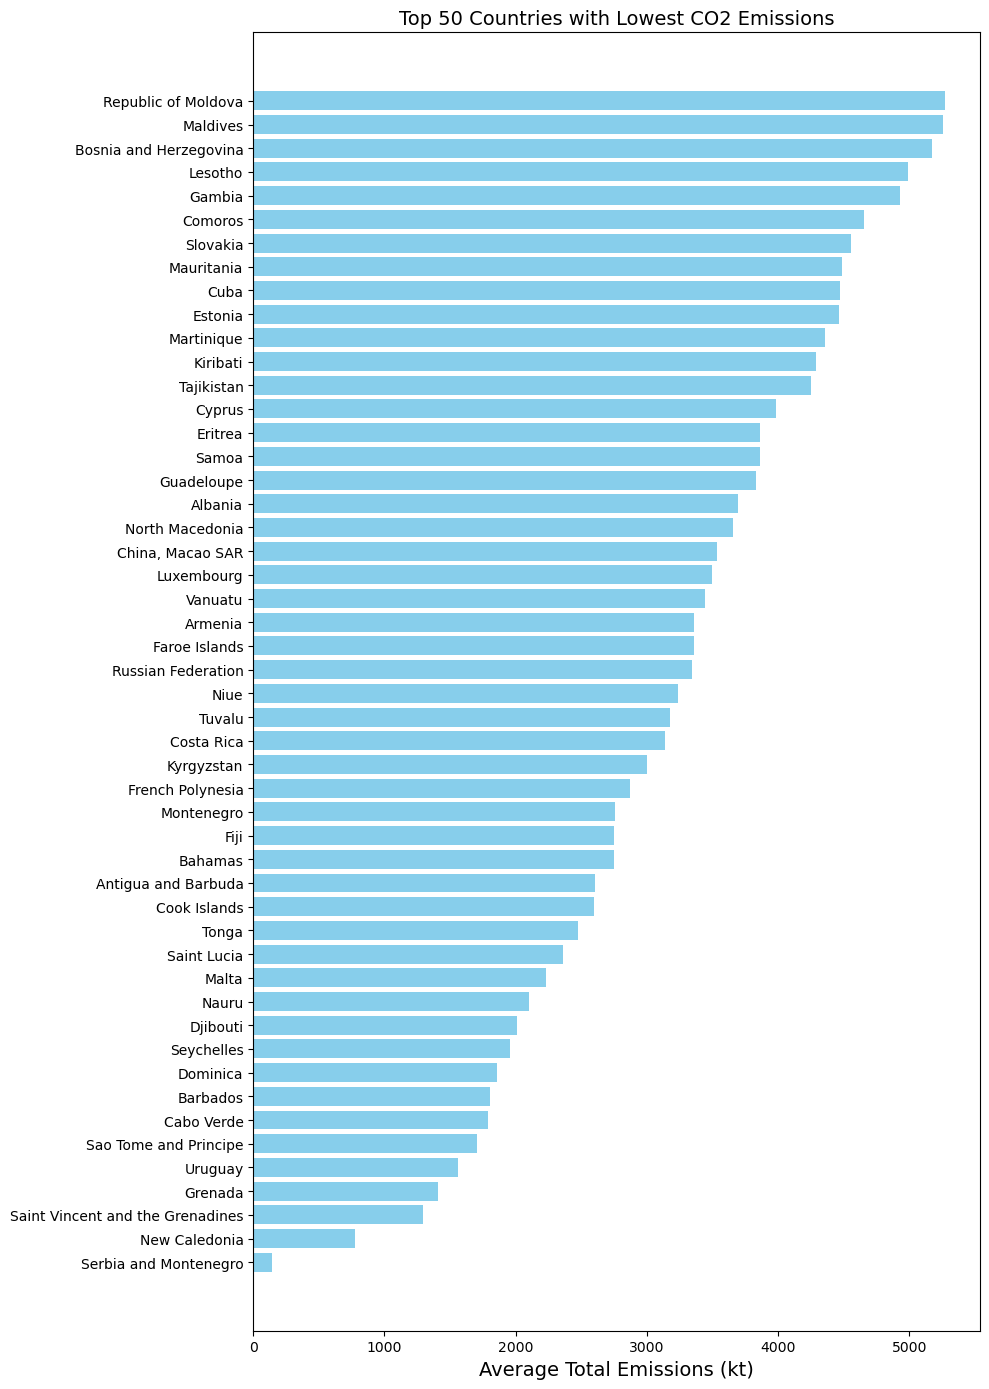

In [27]:
area_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

# Group by area
average_emission_per_country = data_3.groupby('Area')['total_emission'].mean().reset_index()

# Add original names
average_emission_per_country['Area_name'] = average_emission_per_country['Area'].map(area_mapping)

# Sort on average emission
average_emission_per_country_sorted = average_emission_per_country.sort_values(by='total_emission', ascending=False)

# Plot the top 10 countries with the highest average emission
top_50_countries = average_emission_per_country_sorted.head(50)
plt.figure(figsize=(10, 14))
plt.barh(top_50_countries['Area_name'], top_50_countries['total_emission'], color='#FF7F50')
plt.title('Top 50 Countries with Highest CO2 Emissions', fontsize=14)
plt.xlabel('Average Total Emissions (kt)', fontsize=14)
plt.gca().invert_yaxis()
plt.savefig("Top_50_CO2_Emissions.png")
plt.show()

# Filter - emissions 
average_emission_per_country_sorted_filtered = average_emission_per_country_sorted[
    average_emission_per_country_sorted['total_emission'] >= 0
]

# Bottom 50 countries
bottom_50_countries_filtered = average_emission_per_country_sorted_filtered.tail(50)

# Plot for 50 bottom countries
plt.figure(figsize=(10, 14))
plt.barh(bottom_50_countries_filtered['Area_name'], bottom_50_countries_filtered['total_emission'], color='skyblue')
plt.title('Top 50 Countries with Lowest CO2 Emissions', fontsize=14)
plt.xlabel('Average Total Emissions (kt)', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("Bottom_50_CO2_Emissions_Filtered.png")  
plt.show()


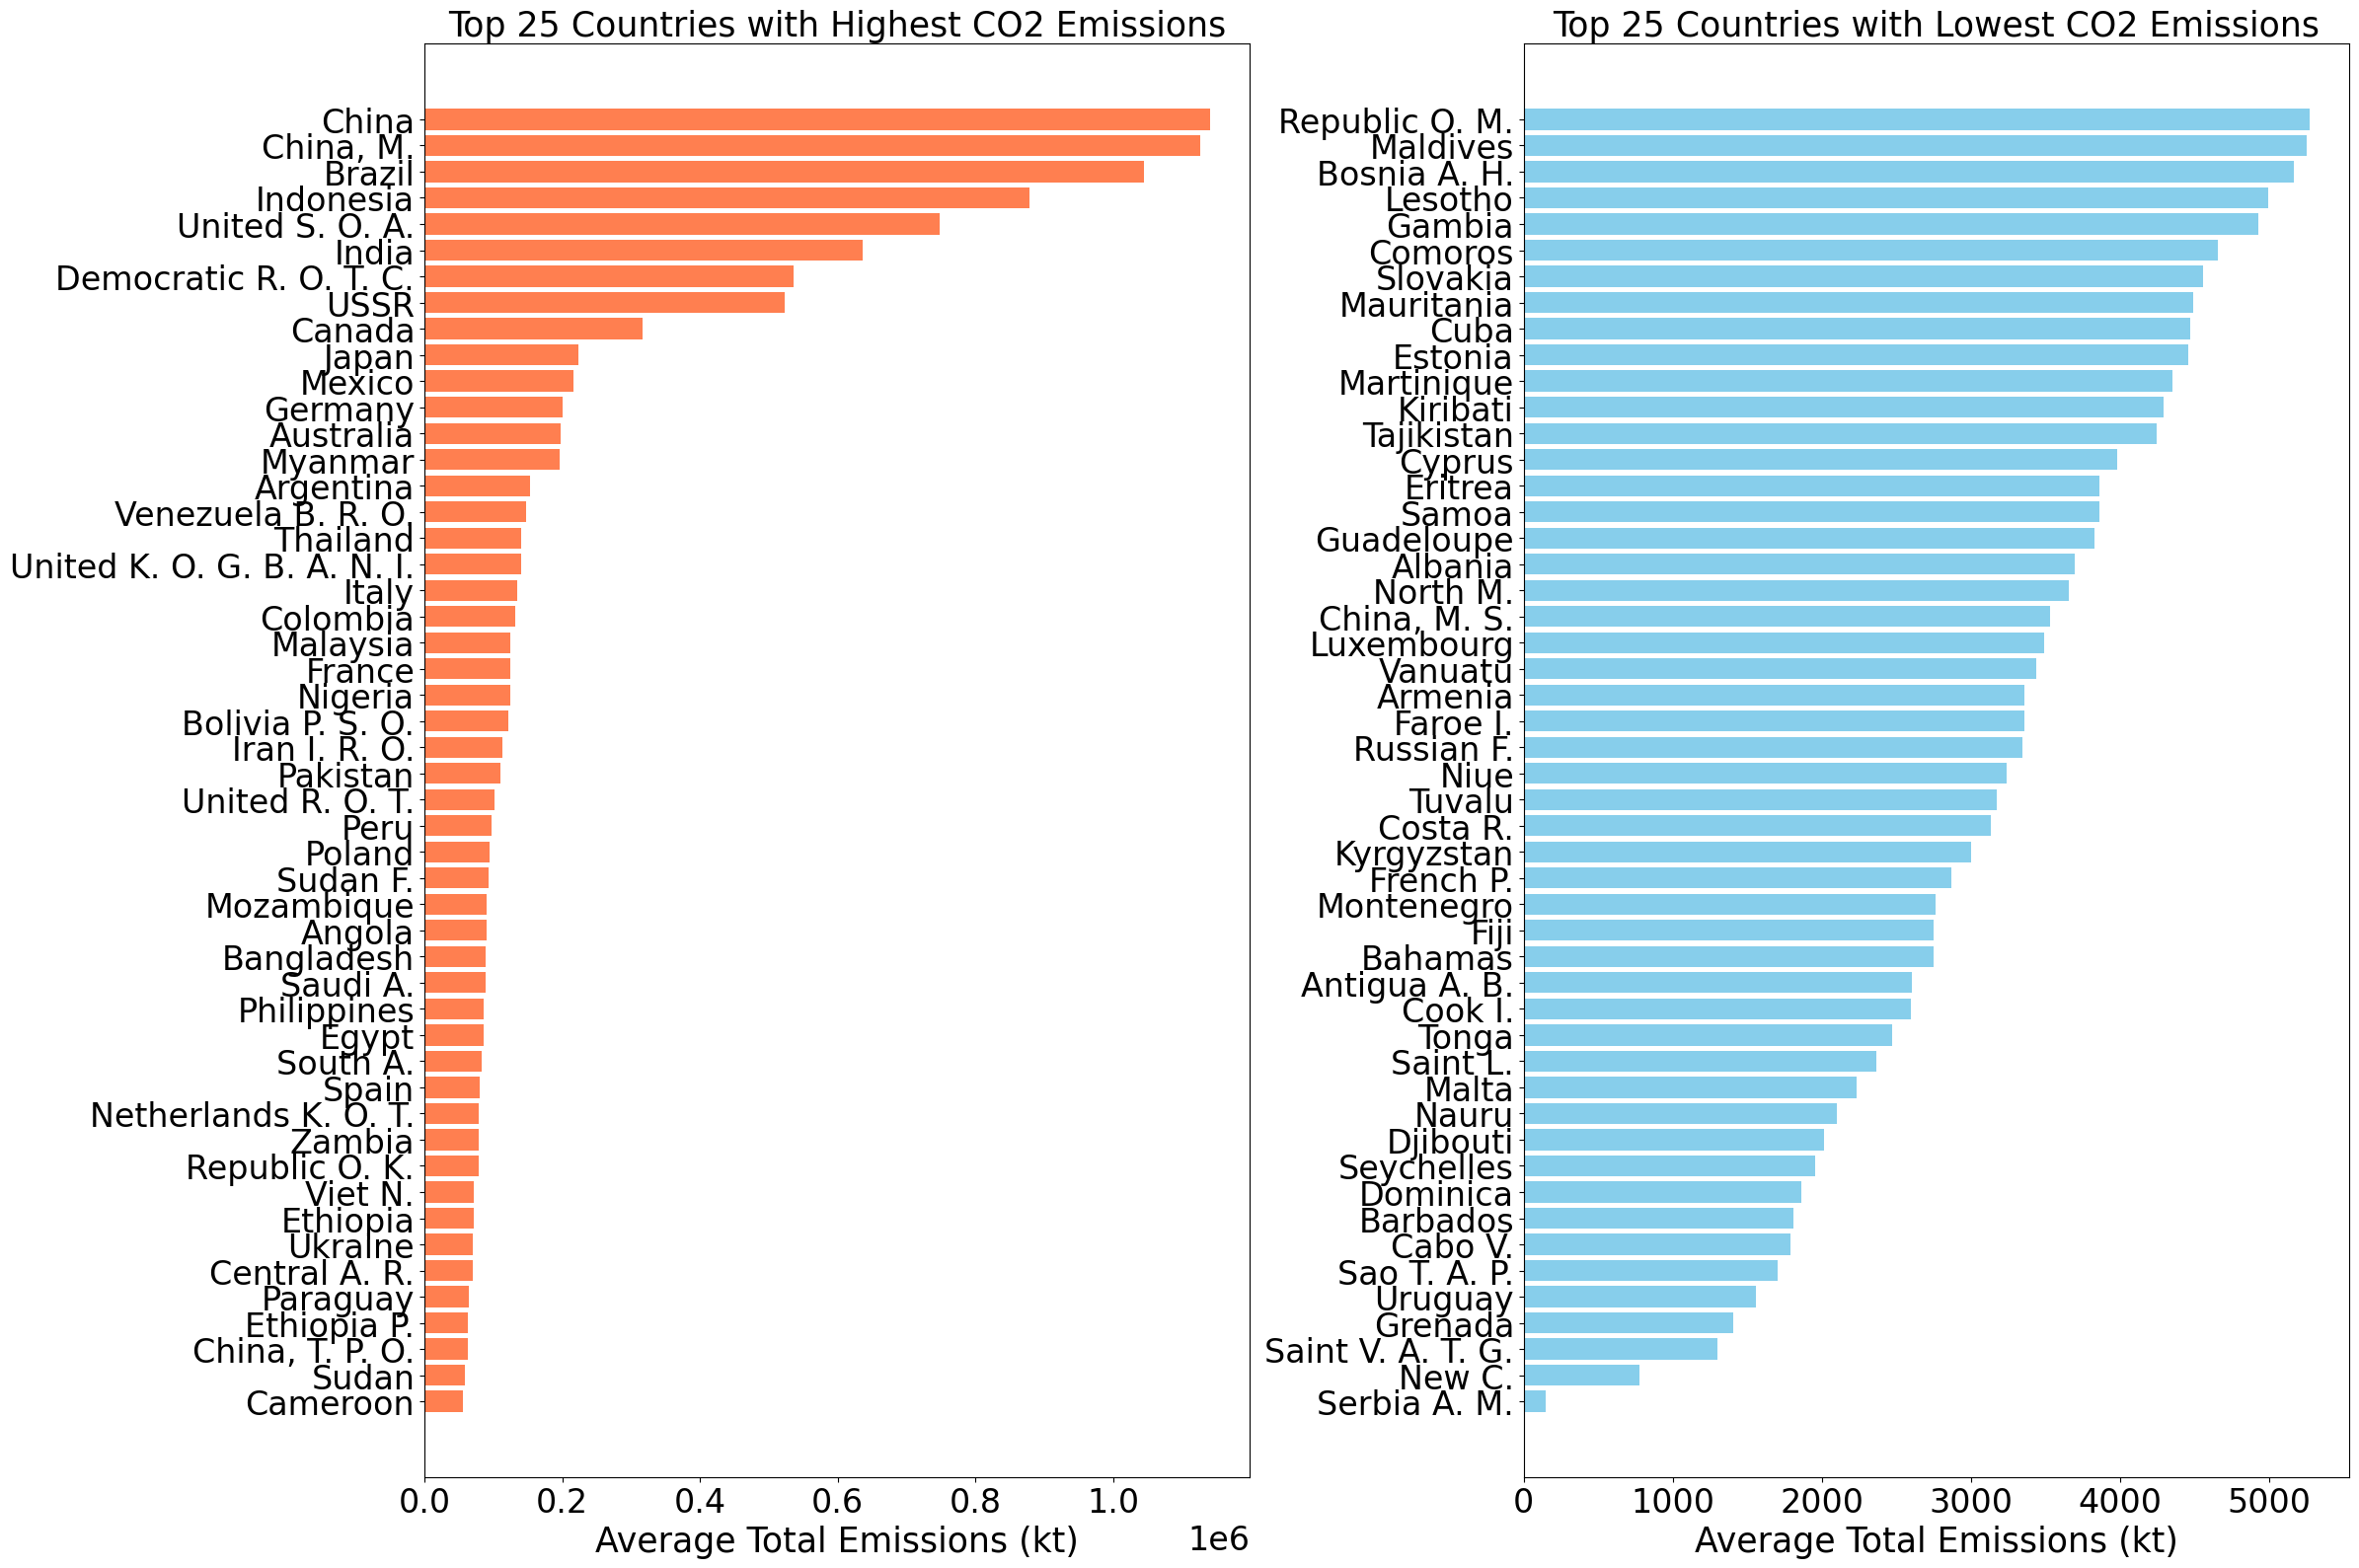

In [28]:
# Generate to smaller words for visualization purposes Overleaf
def create_custom_abbreviation(name):
    words = name.replace('(', '').replace(')', '').split()  
    if len(words) > 1:
        abbreviations = [word[0].upper() + '.' for word in words[1:]]
        return words[0] + ' ' + ' '.join(abbreviations)
    else:
        return name

# List of countries
top_25_countries = top_50_countries.copy()  
bottom_25_countries_filtered = bottom_50_countries_filtered.copy()  

top_25_countries['Area_abbreviation'] = top_25_countries['Area_name'].apply(create_custom_abbreviation)
bottom_25_countries_filtered['Area_abbreviation'] = bottom_25_countries_filtered['Area_name'].apply(create_custom_abbreviation)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(24, 16))

# Plot for the top 25 countries
axes[0].barh(top_25_countries['Area_abbreviation'], top_25_countries['total_emission'], color='#FF7F50')
axes[0].set_title('Top 25 Countries with Highest CO2 Emissions', fontsize=25)
axes[0].set_xlabel('Average Total Emissions (kt)', fontsize=25)
axes[0].invert_yaxis()
axes[0].tick_params(axis='y', labelsize=24)  
axes[0].tick_params(axis='x', labelsize=24) 

# Plot for the bottom 25 countries
axes[1].barh(bottom_25_countries_filtered['Area_abbreviation'], bottom_25_countries_filtered['total_emission'], color='skyblue')
axes[1].set_title('Top 25 Countries with Lowest CO2 Emissions', fontsize=25)
axes[1].set_xlabel('Average Total Emissions (kt)', fontsize=25)
axes[1].invert_yaxis()
axes[1].tick_params(axis='y', labelsize=24)  
axes[1].tick_params(axis='x', labelsize=24)  

# Larger text on the axes
for ax in axes:
    ax.xaxis.get_offset_text().set_fontsize(24)  

# Make the plot
plt.tight_layout()
plt.savefig("Top_and_Bottom_25_CO2_Emissions_Custom_Abbreviations.png")
plt.show()


In [29]:
# Pearson correlation of Area with other features
area_correlations = data_3.corr(method='pearson', numeric_only=True)['Area'].round(2)

# Remove the correlation with 'Area' itselfs
area_correlations_without_self = area_correlations.drop('Area')

# Sort correlations
top_positive_area_correlations = area_correlations_without_self.sort_values(ascending=False).head(10)
top_negative_area_correlations = area_correlations_without_self.sort_values(ascending=True).head(10)

# print results 
print("Top 10 positive correlated features with 'Area':")
print(top_positive_area_correlations)

print("\nTop 10 negative correlated features with 'Area':")
print(top_negative_area_correlations)

Top 10 positive correlated features with 'Area':
Drained organic soils (CO2)    0.06
Food Retail                    0.03
Fires in organic soils         0.01
Forestland                     0.01
Year                           0.00
Food Transport                 0.00
Fertilizers Manufacturing      0.00
Average Temperature °C        -0.01
Food Processing               -0.02
Manure Management             -0.02
Name: Area, dtype: float64

Top 10 negative correlated features with 'Area':
Net Forest conversion             -0.10
Savanna fires                     -0.09
Manure left on Pasture            -0.09
total_emission                    -0.09
Fires in humid tropical forests   -0.08
Rural population                  -0.07
Total Population - Male           -0.07
Agrifood Systems Waste Disposal   -0.07
Total Population - Female         -0.07
Forest fires                      -0.06
Name: Area, dtype: float64


### PCA Analysis

Explained Variance per Component: [5.58414016e-01 9.12870838e-02 6.05324713e-02 4.98360999e-02
 4.41946544e-02 3.36637211e-02 2.98591693e-02 2.40625239e-02
 1.98283753e-02 1.66404455e-02 1.46871996e-02 1.13667862e-02
 8.80973119e-03 6.53359644e-03 5.89673633e-03 4.73278600e-03
 3.40094723e-03 3.04014900e-03 2.53141465e-03 2.44489885e-03
 1.82655074e-03 1.52325727e-03 1.38435140e-03 1.13422985e-03
 1.04145660e-03 6.07970929e-04 3.87578107e-04 2.84240680e-04
 4.56626311e-05 1.89618785e-06]
Top 5 Variables for PC1:
Urban population             0.236614
Manure applied to Soils      0.236349
Manure Management            0.235375
Crop Residues                0.235299
Total Population - Female    0.229219
Name: PC1, dtype: float64

Top 5 Variables for PC2:
Forest fires                       0.541612
Fires in humid tropical forests    0.540265
Net Forest conversion              0.407186
Savanna fires                      0.381111
Fires in organic soils             0.154174
Name: PC2, dtype: fl

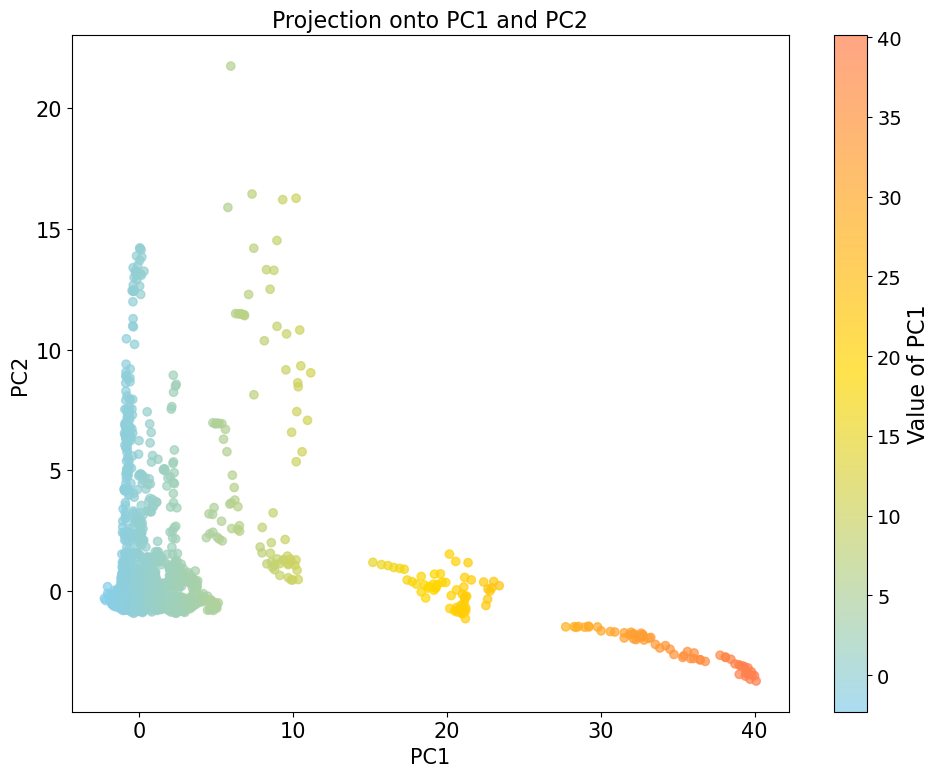

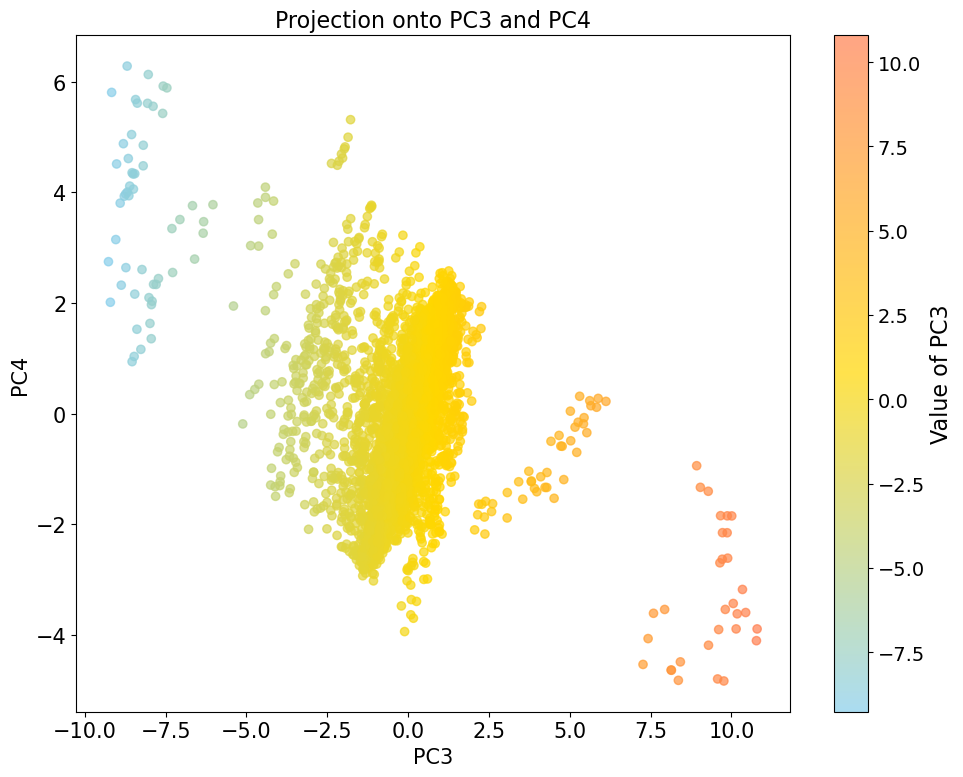

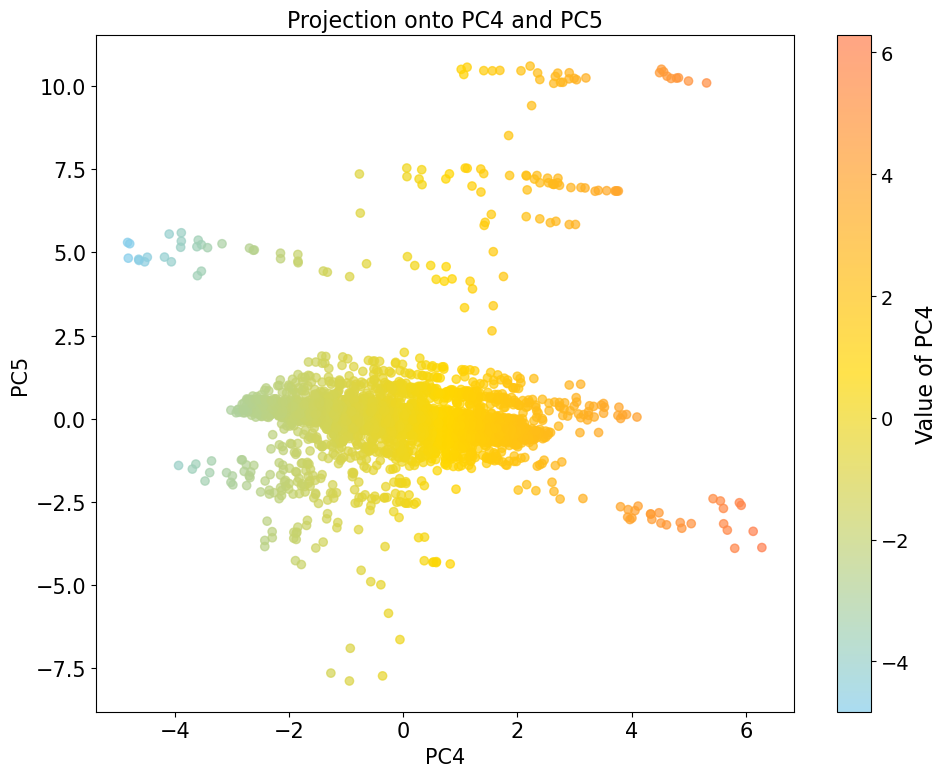

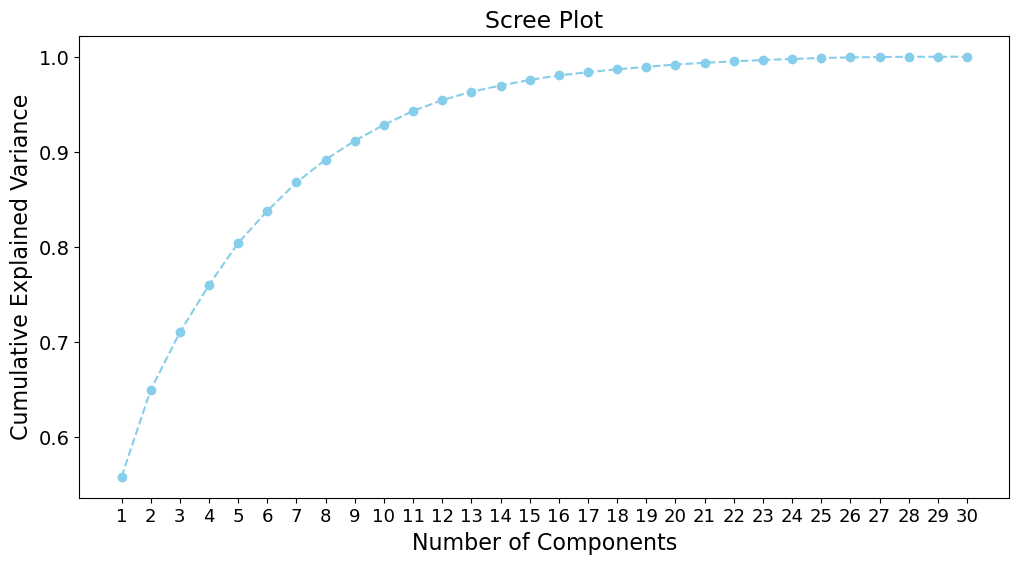

Cumulative explained variance for PC1 to PC10: 0.93


In [78]:
# Make a copy of the data to preserve the original and name it data_copy_PCA
data_copy_PCA = data_3.copy()

# Features without the target variable
features_2 = data_copy_PCA.drop(columns=['total_emission'])

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_2)

# PCA model
pca = PCA()
pca.fit(features_scaled)

# Variance per component
explained_variance = pca.explained_variance_ratio_
print("Explained Variance per Component:", explained_variance)

# Extract the loadings (original variables' contributions to each component)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=features_2.columns  
)

for pc in loadings.columns:
    # Select top 5 variables
    top_loadings = loadings[pc].abs().nlargest(5)
    print(f"Top 5 Variables for {pc}:\n{top_loadings}\n")

# Project data onto the principal components
projected_data = pd.DataFrame(pca.transform(features_scaled), columns=[f'PC{i+1}' for i in range(features_scaled.shape[1])])

# Custom colormap
cmap = LinearSegmentedColormap.from_list(
    "Custom", ["#87CEEB", "#FFD700", "#FF7F50"]
)

# Generate scatterplots for the first 5 PCs
# Pairs of PCs to visualize
pairs = [(1, 2), (3, 4), (4, 5)]  

for pc_x, pc_y in pairs:
    # Use one of the components as color
    color_component = projected_data[f'PC{pc_x}']
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        projected_data[f'PC{pc_x}'], 
        projected_data[f'PC{pc_y}'], 
        c=color_component,  
        cmap=cmap,  # Use the custom colormap
        alpha=0.7
    )
    plt.xlabel(f"PC{pc_x}", fontsize=15)
    plt.ylabel(f"PC{pc_y}", fontsize=15)
    plt.title(f"Projection onto PC{pc_x} and PC{pc_y}", fontsize=16)
    
    # Add colorbar and set its label fontsize
    cbar = plt.colorbar(scatter)
    cbar.set_label(f"Value of PC{pc_x}", fontsize=16)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.savefig(f"scatterplot_pc{pc_x}_pc{pc_y}_colored_by_pc{pc_x}.png", dpi=300)
    plt.show()

# Scree plot to show cumulative explained variance
plt.figure(figsize=(12, 6))
plt.plot(
    range(1, len(explained_variance) + 1),  # Explicitly start x-axis from 1
    np.cumsum(explained_variance),
    marker='o',
    linestyle='--',
    color='skyblue'
)
plt.xlabel("Number of Components", fontsize=16)
plt.ylabel("Cumulative Explained Variance", fontsize=16)
plt.title("Scree Plot", fontsize=17)
plt.xticks(ticks=range(1, len(explained_variance) + 1), fontsize=13)  # Align x-axis ticks with component numbers
plt.yticks(fontsize=14)
plt.savefig("screeplot_cumulative_variance_standardized.png", dpi=300)
plt.show()

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)
# Print cumulative variance for PC1 to PC10
pc1_pc10_variance = cumulative_variance[9]  # Cumulative variance up to PC10
print(f"Cumulative explained variance for PC1 to PC10: {pc1_pc10_variance:.2f}")


### (initial) Feature Selection

In [46]:
# Copy of data
data_4 = data_3.copy()

# Features and target variable
x = data_4.drop(columns= ['total_emission'])
y = data_4['total_emission']
data_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965 entries, 0 to 6964
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Area                             6965 non-null   int32  
 1   Year                             6965 non-null   int64  
 2   Savanna fires                    6965 non-null   float64
 3   Forest fires                     6965 non-null   float64
 4   Crop Residues                    6965 non-null   float64
 5   Rice Cultivation                 6965 non-null   float64
 6   Drained organic soils (CO2)      6965 non-null   float64
 7   Pesticides Manufacturing         6965 non-null   float64
 8   Food Transport                   6965 non-null   float64
 9   Forestland                       6965 non-null   float64
 10  Net Forest conversion            6965 non-null   float64
 11  Food Household Consumption       6965 non-null   float64
 12  Food Retail         

### Spliting data in training and test set

In [47]:
# Splitting the data in training and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

### Scaling 

In [48]:
# Scaling with Standardization on numerical columns
scaler = StandardScaler()
numerical_features = x.select_dtypes(include=['int64', 'float64']).columns

# --- Scaler for X ---
scaler_X = StandardScaler()
x_train_scaled = scaler_X.fit_transform(x_train[numerical_features])
x_test_scaled = scaler_X.transform(x_test[numerical_features])

# --- Scaler for y ---
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

## 3. Model Development 

### Cross-Validation

In [49]:
kf = KFold(n_splits=10, shuffle=True, random_state=0)

### Linear Regression

In [34]:
LR_model = LinearRegression()

# Evaluation lists
mse_list = []
mae_list = []
r2_list = []

# Cross-validation loop
for train_index, val_index in kf.split(x_train_scaled):
    X_train_cv, X_val_cv = x_train_scaled[train_index], x_train_scaled[val_index]
    y_train_cv, y_val_cv = y_train_scaled[train_index], y_train_scaled[val_index]
    
    # Train the model
    LR_model.fit(X_train_cv, y_train_cv)
    
    # Predict y
    y_pred_cv = LR_model.predict(X_val_cv)
    
    # Evaluation of performance 
    mse = mean_squared_error(y_val_cv, y_pred_cv)
    mae = mean_absolute_error(y_val_cv, y_pred_cv)
    r2 = r2_score(y_val_cv, y_pred_cv)
    
    # Add performance to list 
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

# Print the performance scores
print("Average MSE:", np.mean(mse_list), "Standard deviation MSE:", np.std(mse_list))
print("Average MAE:", np.mean(mae_list), "Standard deviation MAE:", np.std(mae_list))
print("Average R²:", np.mean(r2_list), "Standard deviation R²:", np.std(r2_list))

Average MSE: 0.025859766412215147 Standard deviation MSE: 0.006832489496252835
Average MAE: 0.0771176071993748 Standard deviation MAE: 0.004338967210447132
Average R²: 0.9733507822571037 Standard deviation R²: 0.008574953563535263


### Random Forest

In [35]:
RF_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=0)

mse_list = []
mae_list = []
r2_list = []

for train_index, val_index in kf.split(x_train_scaled):
    X_train_cv = x_train_scaled[train_index]
    X_val_cv   = x_train_scaled[val_index]
    y_train_cv = y_train_scaled[train_index]
    y_val_cv   = y_train_scaled[val_index]
    
    # Train the model
    RF_model.fit(X_train_cv, y_train_cv.ravel())
    
    # Predict y on validation fold
    y_pred_cv = RF_model.predict(X_val_cv)
    
    # Evaluation of performance
    mse_fold = mean_squared_error(y_val_cv, y_pred_cv)
    mae_fold = mean_absolute_error(y_val_cv, y_pred_cv)
    r2_fold  = r2_score(y_val_cv, y_pred_cv)
    
    # Add results to the lists
    mse_list.append(mse_fold)
    mae_list.append(mae_fold)
    r2_list.append(r2_fold)

# Print results
print("Cross-Validation results (scaled once on the entire training set):")
print("Average MSE:", np.mean(mse_list), "±", np.std(mse_list))
print("Average MAE:", np.mean(mae_list), "±", np.std(mae_list))
print("Average R²:", np.mean(r2_list),  "±", np.std(r2_list))

Cross-Validation results (scaled once on the entire training set):
Average MSE: 0.008200168042476657 ± 0.006349059984018548
Average MAE: 0.018154843005052705 ± 0.004075456852966493
Average R²: 0.9916682796516705 ± 0.006105949593821755


#### Hyperparameter Tuning RF (remove # for running)

In [36]:
# # RF model without parameters
# RF_model_blanco =  RandomForestRegressor(random_state=0)

#  # Hyperparameter tuning with BayesSearchCV 
# search_spaces = {
#     'n_estimators': (50, 150),
#     'max_depth': (5, 50),
#     'min_samples_split': (2, 10),
#     'min_samples_leaf': (1, 10)
# }

# # BayesSearchCV 
# bayes_search = BayesSearchCV(
#     estimator=RF_model_blanco,
#     search_spaces=search_spaces,
#     n_iter=100,  
#     cv=5,  
#     n_jobs=-1,   
#     random_state=0
# )

# # BayesSearchCV fit
# tuned_model = bayes_search.fit(x_train_scaled, y_train_scaled)

# best_params = bayes_search.best_params_
# print("The best Hyperparameters of RF:", best_params)

#### RF Model with Hyperparmeter Tuning

In [52]:
# Hyperparameters for RF_tuned (Output previous cell with randomstate = 0)
best_params = {
    "n_estimators": 50,
    "max_depth": 28,
    "min_samples_split": 2,
    "min_samples_leaf": 1
}

# RF model
RF_tuned = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=0
)

# Cross-validation loop
mse_list_tuned = []
mae_list_tuned = []
r2_list_tuned = []

for train_index, val_index in kf.split(x_train_scaled):
    X_train_cv = x_train_scaled[train_index]
    X_val_cv   = x_train_scaled[val_index]
    y_train_cv = y_train_scaled[train_index]
    y_val_cv   = y_train_scaled[val_index]
    
    # Train the model
    RF_tuned.fit(X_train_cv, y_train_cv)
    
    # Predict y
    y_pred_val = RF_tuned.predict(X_val_cv)
    
    # Metrics
    mse = mean_squared_error(y_val_cv, y_pred_val)
    mae = mean_absolute_error(y_val_cv, y_pred_val)
    r2  = r2_score(y_val_cv, y_pred_val)
    
    mse_list_tuned.append(mse)
    mae_list_tuned.append(mae)
    r2_list_tuned.append(r2)

print("\nCross-Validation with Hyperparameter Tuning (train set only):")
print("Average MSE:", np.mean(mse_list_tuned), "±", np.std(mse_list_tuned))
print("Average MAE:", np.mean(mae_list_tuned), "±", np.std(mae_list_tuned))
print("Average R²:", np.mean(r2_list_tuned), "±", np.std(r2_list_tuned))

C:\Users\kimos\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kimos\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kimos\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kimos\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for


Cross-Validation with Hyperparameter Tuning (train set only):
Average MSE: 0.008111656570192503 ± 0.006424308733842259
Average MAE: 0.018077966165501363 ± 0.004228987061614666
Average R²: 0.9917499613646585 ± 0.006161350077032495


### Gradient Boosting Machines

In [38]:
GB_model = GradientBoostingRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=0
)

mse_list = []
mae_list = []
r2_list = []


# Cross-validation loop
for train_index, val_index in kf.split(x_train_scaled):
    X_train_cv = x_train_scaled[train_index]
    X_val_cv   = x_train_scaled[val_index]
    
    y_train_cv = y_train_scaled[train_index]
    y_val_cv   = y_train_scaled[val_index]
    
    # Train the model
    GB_model.fit(X_train_cv, y_train_cv.ravel())
    
    # Predict Y
    y_pred_cv = GB_model.predict(X_val_cv)
    
    # Metrics
    mse_fold = mean_squared_error(y_val_cv, y_pred_cv)
    mae_fold = mean_absolute_error(y_val_cv, y_pred_cv)
    r2_fold  = r2_score(y_val_cv, y_pred_cv)
    
    mse_list.append(mse_fold)
    mae_list.append(mae_fold)
    r2_list.append(r2_fold)

# Print results
print("GradientBoostingRegressor (10-fold CV on training set):")
print("Average MSE:", np.mean(mse_list), "±", np.std(mse_list))
print("Average MAE:", np.mean(mae_list), "±", np.std(mae_list))
print("Average R²:", np.mean(r2_list),  "±", np.std(r2_list))

GradientBoostingRegressor (10-fold CV on training set):
Average MSE: 0.010563438462929307 ± 0.005413891164604368
Average MAE: 0.03910354693901787 ± 0.0029398042614615654
Average R²: 0.9892740478670463 ± 0.005211134277581268


#### Hyperparameter Tuning GBM (Remove # for running)

In [63]:
# Baseline Gradient Boosting Regressor
GB_model_blanco = GradientBoostingRegressor(random_state=0, n_iter_no_change=10,
    validation_fraction=0.1)

# Hyperparameter tuning with BayesSearchCV 
search_spaces = {
    'n_estimators': (50, 300),
    'learning_rate': (0.01, 0.2, 'log-uniform'),
    'max_depth': (3, 10),
    'min_samples_split': (2, 25),
    'min_samples_leaf': (5, 40)
}

# BayesSearchCV 
bayes_search = BayesSearchCV(
    estimator=GB_model_blanco,
    search_spaces=search_spaces,
    n_iter=80,  
    cv=5,  
    n_jobs=-1,   
    random_state=0
)

# Fit BayesSearchCV to the data
tuned_modelGBM = bayes_search.fit(x_train_scaled, y_train_scaled.ravel())
best_paramsGBM = tuned_modelGBM.best_params_

print("Best hyperparameters found by BayesSearchCV:", best_paramsGBM)

Best hyperparameters found by BayesSearchCV: OrderedDict([('learning_rate', 0.1535673800388899), ('max_depth', 10), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 50)])


#### GBM model with Hyperparameter Tuning

In [51]:
# Hyperparameters for GBM_tuned (Output previous cell with randomstate = 0)
best_paramsGBM = {
    "learning_rate": 0.1535673800388899,
    "max_depth": 10,
    "min_samples_leaf": 5,
    "min_samples_split": 2,
    "n_estimators": 50
}

# Train GBM with the hyperparameters
GBM_tuned = GradientBoostingRegressor(
    n_estimators=best_paramsGBM['n_estimators'],
    max_depth=best_paramsGBM['max_depth'],
    learning_rate=best_paramsGBM['learning_rate'],
    min_samples_split=best_paramsGBM['min_samples_split'],
    min_samples_leaf=best_paramsGBM['min_samples_leaf'],
    random_state=0
)

# Cross-validation evaluation
mse_list_gbm, mae_list_gbm, r2_list_gbm = [], [], []

for train_index, val_index in kf.split(x_train_scaled):
    X_train_cv = x_train_scaled[train_index]
    X_val_cv   = x_train_scaled[val_index]

    y_train_cv = y_train_scaled[train_index]
    y_val_cv   = y_train_scaled[val_index]

    # Train
    GBM_tuned.fit(X_train_cv, y_train_cv)
    # Predict
    y_pred_cv = GBM_tuned.predict(X_val_cv)

    # Metrics
    mse_list_gbm.append(mean_squared_error(y_val_cv, y_pred_cv))
    mae_list_gbm.append(mean_absolute_error(y_val_cv, y_pred_cv))
    r2_list_gbm.append(r2_score(y_val_cv, y_pred_cv))

print("\nGBM tuned model (10-fold CV op trainingset):")
print("Average MSE:", np.mean(mse_list_gbm), "±", np.std(mse_list_gbm))
print("Average MAE:", np.mean(mae_list_gbm), "±", np.std(mae_list_gbm))
print("Average R²:",  np.mean(r2_list_gbm),  "±", np.std(r2_list_gbm))

C:\Users\kimos\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kimos\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kimos\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kimos\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin


GBM tuned model (10-fold CV op trainingset):
Average MSE: 0.007090514485870973 ± 0.005511802440700315
Average MAE: 0.017846545565390438 ± 0.0035108823719367534
Average R²: 0.9926339962984437 ± 0.005435220128500054


### FNN

In [41]:
FNN_model = MLPRegressor(
    hidden_layer_sizes=(1000,),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=0
)

# Lists for metrics
mse_list = []
mae_list = []
r2_list = []

# Cross-validation loop 
for train_index, val_index in kf.split(x_train_scaled):
    X_train_cv = x_train_scaled[train_index]
    X_val_cv   = x_train_scaled[val_index]
    
    y_train_cv = y_train_scaled[train_index]
    y_val_cv   = y_train_scaled[val_index]
    
    # Train the model
    FNN_model.fit(X_train_cv, y_train_cv.ravel())
    
    # Predict y on validation fold 
    y_pred_cv = FNN_model.predict(X_val_cv)
    
    # Metrics
    mse_fold = mean_squared_error(y_val_cv, y_pred_cv)
    mae_fold = mean_absolute_error(y_val_cv, y_pred_cv)
    r2_fold  = r2_score(y_val_cv, y_pred_cv)
    
    mse_list.append(mse_fold)
    mae_list.append(mae_fold)
    r2_list.append(r2_fold)

print("MLPRegressor (FNN) - 10-fold CV on training set")
print("Average MSE:", np.mean(mse_list), "±", np.std(mse_list))
print("Average MAE:", np.mean(mae_list), "±", np.std(mae_list))
print("Average R²:", np.mean(r2_list),  "±", np.std(r2_list))

MLPRegressor (FNN) - 10-fold CV on training set
Average MSE: 0.006478016685981784 ± 0.002764612392186952
Average MAE: 0.03041617721053516 ± 0.0066300894094355025
Average R²: 0.9933526451070847 ± 0.003111238327838143


#### Hyperparameter Tuning FNN (remove # for running)

In [42]:
# print(type(x), type(y))
# print(x.shape, y.shape)

# # Define the baseline MLPRegressor model
# FNN_model_blanco = MLPRegressor(
#     max_iter=2000,
#     random_state=0,
#     early_stopping=True
# )

# search_spaces = {
#     'hidden_layer_sizes': Categorical([50, 100]),
#     'activation': Categorical(['relu', 'tanh']),
#     'solver': Categorical(['adam', 'lbfgs']),
#     'alpha': Real(1e-4, 5e-4, prior='log-uniform'),
#     'learning_rate_init': Real(1e-4, 1e-2, prior='log-uniform')
# }

# bayes_search = BayesSearchCV(
#     estimator=FNN_model_blanco,
#     search_spaces=search_spaces,
#     n_iter=100,         
#     cv=5,               
#     n_jobs=-1,
#     random_state=0,
#     verbose=3
# )

# # Fit on scaled  trainingset
# tuned_modelFNN = bayes_search.fit(
#     x_train_scaled, 
#     y_train_scaled, 
#     callback=[DeltaYStopper(1e-6)]
# )

# best_paramsFNN = tuned_modelFNN.best_params_
# print("The best hyperparameters for FNN:", best_paramsFNN)

#### FNN with Hyperparameter Tuning

In [43]:
# Hyperparameters for FNN_tuned (Output previous cell with randomstate = 0)
best_paramsFNN = {
    "hidden_layer_sizes": 100,
    "activation": "relu",
    "solver": "lbfgs",
    "alpha": 0.0003346773066991096,
    "learning_rate_init":  0.00010002854402010719
}

    
# Train FNN with hyperparameters
FNN_tuned = MLPRegressor(
    hidden_layer_sizes=best_paramsFNN['hidden_layer_sizes'],
    activation=best_paramsFNN['activation'],
    solver=best_paramsFNN['solver'],
    alpha=best_paramsFNN['alpha'],
    learning_rate='adaptive',   
    learning_rate_init=best_paramsFNN['learning_rate_init'],
    max_iter=5000,
    early_stopping=True,
    random_state=0
)

mse_list_fnn, mae_list_fnn, r2_list_fnn = [], [], []

for train_index, val_index in kf.split(x_train_scaled):
    X_train_cv = x_train_scaled[train_index]
    X_val_cv   = x_train_scaled[val_index]

    y_train_cv = y_train_scaled[train_index]
    y_val_cv   = y_train_scaled[val_index]
    
    # Train the model
    FNN_tuned.fit(X_train_cv, y_train_cv)
    
    # Predict y
    y_pred_cv = FNN_tuned.predict(X_val_cv)
    
    # Metrics
    mse_list_fnn.append(mean_squared_error(y_val_cv, y_pred_cv))
    mae_list_fnn.append(mean_absolute_error(y_val_cv, y_pred_cv))
    r2_list_fnn.append(r2_score(y_val_cv, y_pred_cv))

print("\nFNN Model (10-fold CV on trainingset) with the best hyperparameters:")
print("Mean MSE:", np.mean(mse_list_fnn), "±", np.std(mse_list_fnn))
print("Mean MAE:", np.mean(mae_list_fnn), "±", np.std(mae_list_fnn))
print("Mean R²:", np.mean(r2_list_fnn),  "±", np.std(r2_list_fnn))

C:\Users\kimos\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kimos\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kimos\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kimos\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y 


FNN Model (10-fold CV on trainingset) with the best hyperparameters:
Mean MSE: 0.002333140807172889 ± 0.0016594431523558133
Mean MAE: 0.018103297815164916 ± 0.0016677940770790376
Mean R²: 0.997721102660595 ± 0.0015220317705884048


## Feature Importance Analysis

In [53]:
# Create a copy of x_train
x_train_scaled_df = x_train.copy()

# Overwrite only the numerical columns with their scaled values
x_train_scaled_df[numerical_features] = x_train_scaled

# PGI² typically only needs X for the difference in predictions, but let's keep them consistent:
y_train_scaled_series = pd.Series(y_train_scaled.ravel(), index=x_train.index)

# Train RF
RF_tuned = RandomForestRegressor(**RF_tuned.get_params())
RF_tuned.fit(x_train_scaled_df, y_train) 

# Train GBM
GBM_tuned = GradientBoostingRegressor(**GBM_tuned.get_params())
GBM_tuned.fit(x_train_scaled_df, y_train)

GradientBoostingRegressor(learning_rate=0.1535673800388899, max_depth=10,
                          min_samples_leaf=5, n_estimators=50, random_state=0)

#### PGI² scores

In [54]:
def perturb_features(X, features_to_perturb, std_dev=0.1):
    np.random.seed(0)
    X_perturbed = X.copy()
    for feature in features_to_perturb:
        if feature not in X.columns:
            raise ValueError(f"Feature '{feature}' not found in DataFrame.")
        X_perturbed[feature] += np.random.normal(0, std_dev, size=X.shape[0])
    return X_perturbed

def compute_pgi2(model, X, y, feature_subset, std_dev=0.1):
    """
    Compute the PGI² metric for a given feature subset by perturbing them
    in X and measuring the mean squared difference in model predictions.
    """
    if not isinstance(X, pd.DataFrame):
        raise ValueError(f"Input X must be a pandas DataFrame, but got {type(X)} instead.")
    
    # Original predictions
    original_preds = model.predict(X)
    # Perturb the given subset of features
    perturbed_X = perturb_features(X, feature_subset, std_dev)
    # Predictions after perturbation
    perturbed_preds = model.predict(perturbed_X)
    
    # PGI² = mean of squared differences
    return np.mean((perturbed_preds - original_preds) ** 2)

def compute_average_pgi2(model, X, y, feature_ranking, std_dev=0.1):
    """
    For a given ranking, compute the average PGI² across subsets of increasing size.
    """
    d = len(feature_ranking)
    total_pgi2 = 0.0
    for k in range(1, d + 1):
        subset = feature_ranking[:k]
        pgi2_value = compute_pgi2(model, X, y, subset, std_dev)
        total_pgi2 += pgi2_value
    return total_pgi2 / d

def rank_features_pgi2(model, X, y, std_dev=0.1):
    """
    A greedy approach: at each step, pick the feature that yields
    the greatest increase in PGI² when added.
    """
    feature_indices = list(range(X.shape[1]))
    feature_names = X.columns.tolist()
    ranked_features = []
    remaining_features = set(feature_indices)
    
    while remaining_features:
        best_feature = None
        best_pgi2 = -np.inf
        
        for feature in remaining_features:
            current_subset = ranked_features + [feature_names[feature]]
            pgi2_value = compute_pgi2(model, X, y, current_subset, std_dev)
            if pgi2_value > best_pgi2:
                best_pgi2 = pgi2_value
                best_feature = feature
        
        ranked_features.append(feature_names[best_feature])
        remaining_features.remove(best_feature)
    
    return ranked_features
# -----------------------------------------------------------------------------------------

# Apply 5-fold CV for PGI²
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Store fold results in these lists
fold_rankings_rf = []
fold_rankings_gbm = []
fold_avgpgi2_rf = []
fold_avgpgi2_gbm = []

fold_idx = 1

for train_index, val_index in kf.split(x_train_scaled_df):
    print(f"\n=== Fold {fold_idx} ===")
    
    # Split data
    X_train_cv = x_train_scaled_df.iloc[train_index]
    X_val_cv   = x_train_scaled_df.iloc[val_index]
    
    y_train_cv = y_train.iloc[train_index]
    y_val_cv   = y_train.iloc[val_index]
    
    # Clone the model so we don't overwrite the same instance
    rf_clone = clone(RF_tuned)
    gbm_clone = clone(GBM_tuned)
    
    # Fit on the train fold
    rf_clone.fit(X_train_cv, y_train_cv)
    gbm_clone.fit(X_train_cv, y_train_cv)
    
    # Rank features on the validation fold
    rf_fold_ranking = rank_features_pgi2(rf_clone, X_val_cv, y_val_cv)
    gbm_fold_ranking = rank_features_pgi2(gbm_clone, X_val_cv, y_val_cv)
    
    fold_rankings_rf.append(rf_fold_ranking)
    fold_rankings_gbm.append(gbm_fold_ranking)
    
    # Compute average PGI² on the validation fold, using the fold-based ranking
    rf_avg_pgi2_fold = compute_average_pgi2(rf_clone, X_val_cv, y_val_cv, rf_fold_ranking)
    gbm_avg_pgi2_fold = compute_average_pgi2(gbm_clone, X_val_cv, y_val_cv, gbm_fold_ranking)
    
    fold_avgpgi2_rf.append(rf_avg_pgi2_fold)
    fold_avgpgi2_gbm.append(gbm_avg_pgi2_fold)
    
    print("RF feature ranking:", rf_fold_ranking)
    print("RF average PGI² (val fold):", rf_avg_pgi2_fold)
    
    print("GBM feature ranking:", gbm_fold_ranking)
    print("GBM average PGI² (val fold):", gbm_avg_pgi2_fold)
    
    fold_idx += 1

# Summaries across folds
print("\n=== Summary over 5 folds ===")
print("RF fold-wise rankings:")
for i, ranking in enumerate(fold_rankings_rf, start=1):
    print(f"  Fold {i}: {ranking}")
print("Mean RF average PGI² over folds =", 
      np.mean(fold_avgpgi2_rf), "+/-", np.std(fold_avgpgi2_rf))

print("\nGBM fold-wise rankings:")
for i, ranking in enumerate(fold_rankings_gbm, start=1):
    print(f"  Fold {i}: {ranking}")
print("Mean GBM average PGI² over folds =", 
      np.mean(fold_avgpgi2_gbm), "+/-", np.std(fold_avgpgi2_gbm))


=== Fold 1 ===
RF feature ranking: ['Net Forest conversion', 'Rural population', 'Agrifood Systems Waste Disposal', 'Rice Cultivation', 'Food Processing', 'Manure Management', 'Savanna fires', 'Total Population - Male', 'IPPU', 'Urban population', 'On-farm Electricity Use', 'Forestland', 'Fertilizers Manufacturing', 'Fires in humid tropical forests', 'Food Household Consumption', 'Drained organic soils (CO2)', 'Manure applied to Soils', 'Food Packaging', 'Total Population - Female', 'Food Retail', 'Manure left on Pasture', 'Forest fires', 'Crop Residues', 'Pesticides Manufacturing', 'Food Transport', 'On-farm energy use', 'Average Temperature °C', 'Fires in organic soils', 'Year', 'Area']
RF average PGI² (val fold): 678813588.9201123
GBM feature ranking: ['Rural population', 'Savanna fires', 'Agrifood Systems Waste Disposal', 'Net Forest conversion', 'Food Processing', 'Food Household Consumption', 'Manure Management', 'Total Population - Male', 'Urban population', 'Total Population -

### Ploting the feature importance

Cross-validation-based feature ranking (Random Forest):
['Rural population', 'Agrifood Systems Waste Disposal', 'Rice Cultivation', 'Net Forest conversion', 'Urban population', 'Food Processing', 'IPPU', 'Total Population - Male', 'On-farm Electricity Use', 'Manure Management', 'Food Household Consumption', 'Savanna fires', 'Drained organic soils (CO2)', 'Manure left on Pasture', 'Forestland', 'Fires in humid tropical forests', 'Manure applied to Soils', 'Total Population - Female', 'Fertilizers Manufacturing', 'Crop Residues', 'Food Transport', 'Pesticides Manufacturing', 'Food Packaging', 'On-farm energy use', 'Food Retail', 'Average Temperature °C', 'Forest fires', 'Fires in organic soils', 'Year', 'Area']

Average PGI² scores (RF):
Rural population: 1.6000
Agrifood Systems Waste Disposal: 3.0000
Rice Cultivation: 3.8000
Net Forest conversion: 4.2000
Urban population: 5.0000
Food Processing: 6.6000
IPPU: 7.8000
Total Population - Male: 8.4000
On-farm Electricity Use: 9.2000
Manure M

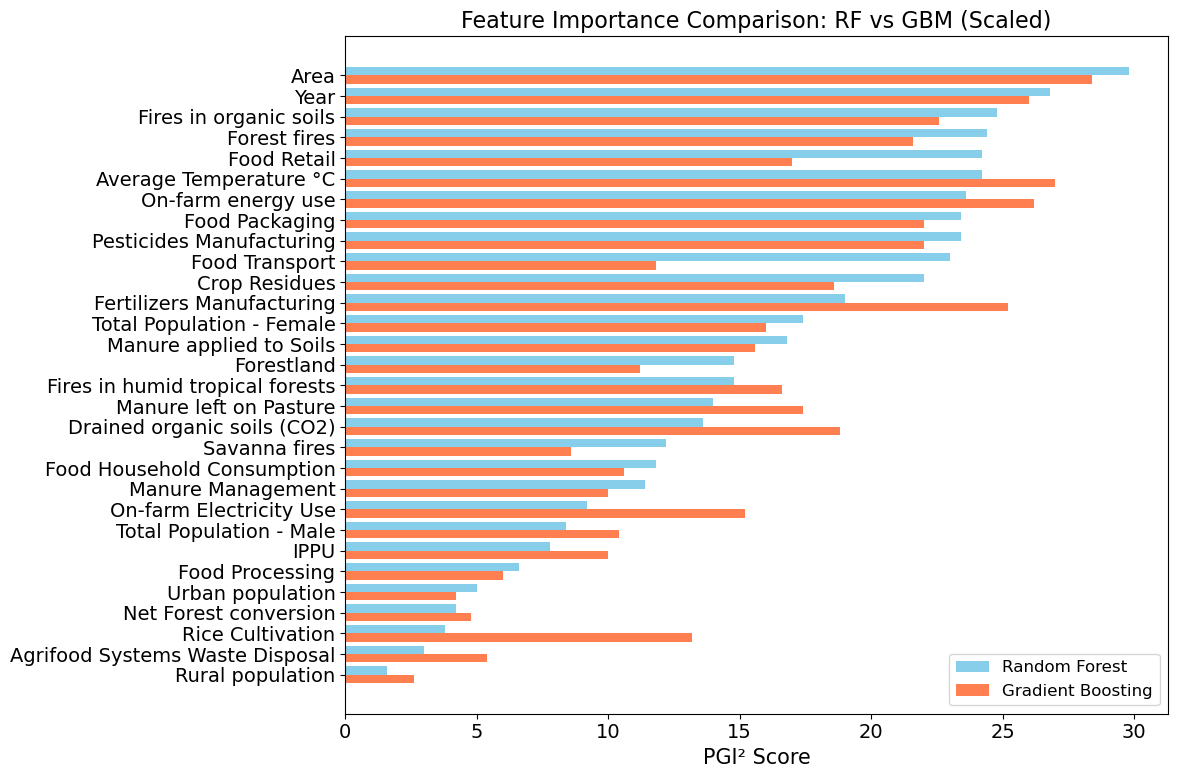

In [57]:
def rank_features_with_scores_cv(base_model, X, y, n_splits=5, std_dev=0.1):
    """
    Perform a 5-fold cross-validation version of the greedy PGI² ranking.
    - In each fold, train on the train split and compute the PGI² ranking on the val split.
    - Finally, average the PGI² scores per feature across folds.
    
    Returns:
        final_sorted_features: list of features sorted by their average PGI² (descending).
        avg_scores: dict of {feature: mean PGI² score over folds}.
        fold_rankings: list of the fold-wise rankings (one list per fold).
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    
    fold_scores_list = []  # Will store the "scores dict" from each fold
    fold_rankings = []     # Will store the "ranking list" from each fold
    
    for train_idx, val_idx in kf.split(X):
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_val_fold   = X.iloc[val_idx]
        y_val_fold   = y.iloc[val_idx]
        
        # Clone the base model so we don't keep re-fitting the same instance
        model_clone = clone(base_model)
        model_clone.fit(X_train_fold, y_train_fold)
        
        # Greedy PGI² ranking on the validation fold
        ranking_fold = rank_features_pgi2(model_clone, X_val_fold, y_val_fold, std_dev)
        fold_rankings.append(ranking_fold)
    
    # Now we combine the per-fold rankings by computing average scores
    all_features = X.columns.tolist()
    avg_scores = {feat: 0.0 for feat in all_features}
    
    # Sum up scores based on the position in each fold's ranking
    for feature in all_features:
        total_rank = 0
        count = 0
        for fold_ranking in fold_rankings:
            if feature in fold_ranking:
                total_rank += fold_ranking.index(feature) + 1  # Convert to 1-based index
                count += 1
        if count > 0:
            avg_scores[feature] = total_rank / count
    
    # Sort features by their average ranks (ascending, lower is better)
    final_sorted_features = sorted(avg_scores.keys(), key=lambda f: avg_scores[f])
    
    return final_sorted_features, avg_scores, fold_rankings

# For Random Forest
rf_cv_features, rf_cv_scores, rf_cv_rankings = rank_features_with_scores_cv(
    base_model=RF_tuned,
    X=x_train_scaled_df,
    y=y_train,
    n_splits=5,
    std_dev=0.1
)

print("Cross-validation-based feature ranking (Random Forest):")
print(rf_cv_features)
print("\nAverage PGI² scores (RF):")
for f in rf_cv_features:
    print(f"{f}: {rf_cv_scores[f]:.4f}")

# For Gradient Boosting
gbm_cv_features, gbm_cv_scores, gbm_cv_rankings = rank_features_with_scores_cv(
    base_model=GBM_tuned,
    X=x_train_scaled_df,
    y=y_train,
    n_splits=5,
    std_dev=0.1
)

print("\nCross-validation-based feature ranking (GBM):")
print(gbm_cv_features)
print("\nAverage PGI² scores (GBM):")
for f in gbm_cv_features:
    print(f"{f}: {gbm_cv_scores[f]:.4f}")

# Convert to a DataFrame:
combined_scores = pd.DataFrame({
    "Feature": rf_cv_scores.keys(),
    "RF_PGI²_Score": rf_cv_scores.values(),
    "GBM_PGI²_Score": gbm_cv_scores.values()
})

# Sort by the RF scores for consistency
combined_scores = combined_scores.sort_values("RF_PGI²_Score", ascending=False).reset_index(drop=True)

# Plot settings
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.4
indices = np.arange(len(combined_scores))

# Plot RF scores
ax.barh(indices - width/2, combined_scores["RF_PGI²_Score"],
        height=width, label="Random Forest", color='skyblue')

# Plot GBM scores
ax.barh(indices + width/2, combined_scores["GBM_PGI²_Score"],
        height=width, label="Gradient Boosting", color='#FF7F50')

# Add labels, title, and legend
ax.set_yticks(indices)
ax.set_yticklabels(combined_scores["Feature"], fontsize=14)
ax.set_xlabel("PGI² Score", fontsize=15)
ax.set_title("Feature Importance Comparison: RF vs GBM (Scaled)", fontsize=16)
ax.legend(fontsize=12)

# Invert y-axis for better readability
plt.gca().invert_yaxis()

# Adjust layout and save plot
plt.tight_layout()
plt.savefig("feature_comparison_RF_vs_GBM.png")
plt.show()


#### Highest rankings

In [60]:
import pandas as pd

def combine_model_rankings_clean(rf_scores, gb_scores):
    """
    Combine feature rankings from RF and GBM into a single DataFrame with highest ranking.
    Sort by RF rank by default.
    """
    combined_rankings = pd.DataFrame({
        "Feature": list(rf_scores.keys()),
        "RF_Rank": pd.Series(rf_scores).rank(ascending=False).astype(int),
        "GBM_Rank": pd.Series(gb_scores).rank(ascending=False).astype(int)
    }).set_index("Feature")

    combined_rankings = combined_rankings.sort_values(by="RF_Rank")
    return combined_rankings

# Combine feature rankings
combined_rankings_clean = combine_model_rankings_clean(rf_cv_scores, gbm_cv_scores)
print("\nCombined Rank (RF vs GBM):")
print(combined_rankings_clean)

# Calculate the top 10 features with the largest ranking differences
def largest_ranking_differences(rf_scores, gb_scores):
    """
    Identify the top 10 features with the largest absolute differences
    in rankings between RF and GBM.
    """
    combined_rankings = pd.DataFrame({
        "Feature": list(rf_scores.keys()),
        "RF_Rank": pd.Series(rf_scores).rank(ascending=False).astype(int),
        "GBM_Rank": pd.Series(gb_scores).rank(ascending=False).astype(int)
    })
    combined_rankings["Rank_Difference"] = (combined_rankings["RF_Rank"] - combined_rankings["GBM_Rank"]).abs()

    largest_differences = combined_rankings.sort_values(by="Rank_Difference", ascending=False).head(10)
    return largest_differences

# Identify top 10 features with largest ranking differences
top_10_differences = largest_ranking_differences(rf_cv_scores, gbm_cv_scores)
print("\nTop 10 features with largest ranking differences:")
print(top_10_differences)



Combined Rank (RF vs GBM):
                                 RF_Rank  GBM_Rank
Feature                                           
Area                                   1         1
Year                                   2         4
Fires in organic soils                 3         6
Forest fires                           4         9
Food Retail                            5        13
Average Temperature °C                 5         2
On-farm energy use                     7         3
Food Packaging                         8         7
Pesticides Manufacturing               8         7
Food Transport                        10        19
Crop Residues                         11        11
Fertilizers Manufacturing             12         5
Total Population - Female             13        15
Manure applied to Soils               14        16
Forestland                            15        20
Fires in humid tropical forests       15        14
Manure left on Pasture                17        12
Dra

#### Lowest rankings

In [62]:
import pandas as pd

def lowest_ranking_features(rf_scores, gb_scores, top_n=10):
    """
    Identify features with the lowest combined rankings from RF and GBM.
    """
    combined_rankings = pd.DataFrame({
        "Feature": list(rf_scores.keys()),
        "RF_Rank": pd.Series(rf_scores).rank(ascending=False).astype(int),
        "GBM_Rank": pd.Series(gb_scores).rank(ascending=False).astype(int)
    })
    combined_rankings["Combined_Rank"] = combined_rankings["RF_Rank"] + combined_rankings["GBM_Rank"]

    lowest_ranked = combined_rankings.sort_values(by="Combined_Rank", ascending=False).head(top_n)
    return lowest_ranked

# Identify the lowest ranked features
lowest_10_ranked_features = lowest_ranking_features(rf_cv_scores, gbm_cv_scores)
print("\nLowest 10 combined-ranked features:")
print(lowest_10_ranked_features)

def sort_worst_rankings(rf_scores, gb_scores):
    """
    Combine feature rankings and sort by the lowest priority features
    (highest rank values).
    """
    combined_rankings = pd.DataFrame({
        "Feature": list(rf_scores.keys()),
        "RF_Rank": pd.Series(rf_scores).rank(ascending=False).astype(int),
        "GBM_Rank": pd.Series(gb_scores).rank(ascending=False).astype(int)
    })
    combined_rankings["Max_Rank"] = combined_rankings[["RF_Rank", "GBM_Rank"]].max(axis=1)
    combined_rankings = combined_rankings.sort_values(by="Max_Rank", ascending=False)

    return combined_rankings.drop(columns=["Max_Rank"])

# Sort worst-ranked features on top
worst_ranked_features = sort_worst_rankings(rf_cv_scores, gbm_cv_scores)
print("\nWorst-ranked features sorted (descending rank):")
print(worst_ranked_features)



Lowest 10 combined-ranked features:
                                                         Feature  RF_Rank  \
Rural population                                Rural population       30   
Agrifood Systems Waste Disposal  Agrifood Systems Waste Disposal       29   
Net Forest conversion                      Net Forest conversion       27   
Urban population                                Urban population       26   
Food Processing                                  Food Processing       25   
IPPU                                                        IPPU       24   
Rice Cultivation                                Rice Cultivation       28   
Total Population - Male                  Total Population - Male       23   
Savanna fires                                      Savanna fires       19   
Manure Management                              Manure Management       21   

                                 GBM_Rank  Combined_Rank  
Rural population                       30             60

#### Average Ranking

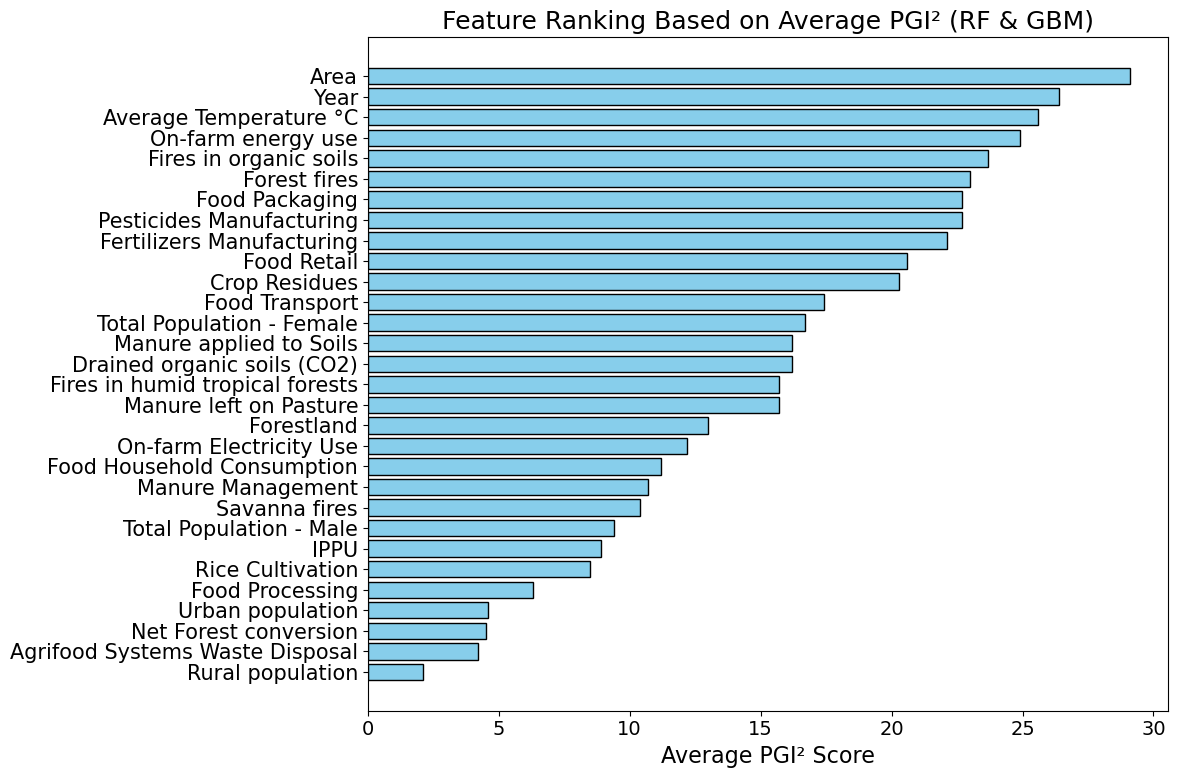

                            Feature  RF_PGI²_Score  GBM_PGI²_Score  \
0                              Area           29.8            28.4   
1                              Year           26.8            26.0   
2            Average Temperature °C           24.2            27.0   
3                On-farm energy use           23.6            26.2   
4            Fires in organic soils           24.8            22.6   
5                      Forest fires           24.4            21.6   
6                    Food Packaging           23.4            22.0   
7          Pesticides Manufacturing           23.4            22.0   
8         Fertilizers Manufacturing           19.0            25.2   
9                       Food Retail           24.2            17.0   
10                    Crop Residues           22.0            18.6   
11                   Food Transport           23.0            11.8   
12        Total Population - Female           17.4            16.0   
13          Manure a

In [68]:
# Compute the average PGI² score across RF and GBM
combined_scores["Average_PGI²_Score"] = combined_scores[["RF_PGI²_Score", "GBM_PGI²_Score"]].mean(axis=1)

# Sort by the average PGI² score
combined_scores_sorted = combined_scores.sort_values("Average_PGI²_Score", ascending=False).reset_index(drop=True)

# Plot the average PGI² scores
plt.figure(figsize=(12, 8))
plt.barh(
    np.arange(len(combined_scores_sorted)),
    combined_scores_sorted["Average_PGI²_Score"],
    color="skyblue",
    edgecolor="black"
)
plt.yticks(
    np.arange(len(combined_scores_sorted)),
    combined_scores_sorted["Feature"],
    fontsize=15
)
plt.xlabel("Average PGI² Score", fontsize=16)
plt.title("Feature Ranking Based on Average PGI² (RF & GBM)", fontsize=18)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("feature_ranking_avg_PGI²_RF_GBM.png")
plt.show()

print(combined_scores_sorted)


## Feature selection 2 

In [124]:
# Define thresholds dynamically based on percentiles
rf_threshold = np.percentile(list(rf_scores.values()), 10)  # Top 90%
gb_threshold = np.percentile(list(gb_scores.values()), 10)  # Top 90%

# Filter features based on dynamic thresholds
selected_features_rf = [feature for feature, score in rf_scores.items() if score > rf_threshold]
selected_features_gb = [feature for feature, score in gb_scores.items() if score > gb_threshold]

# Print the number of features selected based on dynamic thresholds
print("Features with RF PGI² > 25th percentile:", len(selected_features_rf))
print("Features with GBM PGI² > 25th percentile:", len(selected_features_gb))

# Use dynamically selected features for x_selected
x_selected_rf = x[selected_features_rf]
x_selected_gb = x[selected_features_gb]

x_selected_rf.info()
x_selected_gb.info()
# selected_features_combined = list(set(selected_features_rf + selected_features_gb))
#x_selected_combined = x[selected_features_combined]

Features with RF PGI² > 25th percentile: 27
Features with GBM PGI² > 25th percentile: 27
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965 entries, 0 to 6964
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Area                             6965 non-null   int32  
 1   Year                             6965 non-null   int64  
 2   Savanna fires                    6965 non-null   float64
 3   Forest fires                     6965 non-null   float64
 4   Crop Residues                    6965 non-null   float64
 5   Rice Cultivation                 6965 non-null   float64
 6   Drained organic soils (CO2)      6965 non-null   float64
 7   Pesticides Manufacturing         6965 non-null   float64
 8   Food Transport                   6965 non-null   float64
 9   Forestland                       6965 non-null   float64
 10  Net Forest conversion            6965 non-null   float6

In [125]:
# Splitting the new dataset using dynamically selected features
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(
    x_selected_rf,  # Use the selected features
    y, 
    test_size=0.2, 
    random_state=0
)

# Scaling the data (features and target)
scaler_X_2 = StandardScaler()
x_train_scaled_2 = scaler_X_2.fit_transform(x_train_2)  # Fit-transform for training data
x_test_scaled_2 = scaler_X_2.transform(x_test_2)  # Transform for test data

scaler_y_2 = StandardScaler()
y_train_scaled_2 = scaler_y_2.fit_transform(y_train_2.values.reshape(-1, 1))  # Scaling the target variable
y_test_scaled_2 = scaler_y_2.transform(y_test_2.values.reshape(-1, 1))  # Apply same transformation

# Cross-validation setup
kf_2 = KFold(n_splits=10, shuffle=True, random_state=0)  # 10-fold CV with shuffled splits


### LR Performance after Feature Selection

In [126]:
# Cross-validation with Linear Regression
LR_model_tuned2 = LinearRegression()

mse_list_lr, mae_list_lr, r2_list_lr = [], [], []

# Cross-validation loop
for train_index, val_index in kf_2.split(x_train_scaled_2):  
    x_train_fold, x_val_fold = x_train_scaled_2[train_index], x_train_scaled_2[val_index]
    y_train_fold, y_val_fold = y_train_scaled_2[train_index], y_train_scaled_2[val_index]
    
    # Train the model
    LR_model_tuned2.fit(x_train_fold, y_train_fold)
    
    # Predict y
    y_pred_fold = LR_model_tuned2.predict(x_val_fold)
    
    # Evaluate the model
    mse_list_lr.append(mean_squared_error(y_val_fold, y_pred_fold))
    mae_list_lr.append(mean_absolute_error(y_val_fold, y_pred_fold))
    r2_list_lr.append(r2_score(y_val_fold, y_pred_fold))

# Print the results
print("\nLinear Regression Performance after Feature Selection:")
print("Average MSE:", np.mean(mse_list_lr), "Standard deviation MSE:", np.std(mse_list_lr))
print("Average MAE:", np.mean(mae_list_lr), "Standard deviation MAE:", np.std(mae_list_lr))
print("Average R²:", np.mean(r2_list_lr), "Standard deviation R²:", np.std(r2_list_lr))


Linear Regression Performance after Feature Selection:
Average MSE: 0.030897100612909185 Standard deviation MSE: 0.008465471122187129
Average MAE: 0.07735144567639178 Standard deviation MAE: 0.004690492566917475
Average R²: 0.9684724382994199 Standard deviation R²: 0.009662923827392445


### RF Performance after Feature Selection

In [127]:
# Random Forest Performance after Feature Selection
RF_tuned2 = RandomForestRegressor(**RF_tuned.get_params())

mse_list_rf, mae_list_rf, r2_list_rf = [], [], []

# Cross-validation loop
for train_index, val_index in kf_2.split(x_train_scaled_2):
    X_train_cv = x_train_scaled_2[train_index]
    X_val_cv   = x_train_scaled_2[val_index]
    y_train_cv = y_train_scaled_2[train_index]
    y_val_cv   = y_train_scaled_2[val_index]
    
    # Train het model
    RF_tuned2.fit(X_train_cv, y_train_cv.ravel())
    
    # Voorspel y op de validatieset
    y_pred_cv = RF_tuned2.predict(X_val_cv)
    
    # Bereken evaluatiestatistieken
    mse_list_rf.append(mean_squared_error(y_val_cv, y_pred_cv))
    mae_list_rf.append(mean_absolute_error(y_val_cv, y_pred_cv))
    r2_list_rf.append(r2_score(y_val_cv, y_pred_cv))

# Print Random Forest results
print("\nRandom Forest Performance after Feature Selection:")
print("Average MSE:", np.mean(mse_list_rf), "±", np.std(mse_list_rf))
print("Average MAE:", np.mean(mae_list_rf), "±", np.std(mae_list_rf))
print("Average R²:", np.mean(r2_list_rf), "±", np.std(r2_list_rf))


Random Forest Performance after Feature Selection:
Average MSE: 0.010532681906577893 ± 0.008706888183117026
Average MAE: 0.019702045833879543 ± 0.004395854167249658
Average R²: 0.9897491869339472 ± 0.007970736191585462


### GBM Performance after Feature Selection

In [128]:
# Gradient Boosting Performance after Feature Selection
GBM_tuned2 = GradientBoostingRegressor(**GBM_tuned.get_params())

mse_list_gbm_fs, mae_list_gbm_fs, r2_list_gbm_fs = [], [], []

# Cross-validation loop
for train_index, val_index in kf_2.split(x_train_scaled_2):
    x_train_fold, x_val_fold = x_train_scaled_2[train_index], x_train_scaled_2[val_index]
    y_train_fold, y_val_fold = y_train_scaled_2[train_index], y_train_scaled_2[val_index]
    
    # Train the model
    GBM_tuned2.fit(x_train_fold, y_train_fold.ravel())
    
    # Predict y
    y_pred_fold = GBM_tuned2.predict(x_val_fold)
    
    # Evaluate the model
    mse_list_gbm_fs.append(mean_squared_error(y_val_fold, y_pred_fold))
    mae_list_gbm_fs.append(mean_absolute_error(y_val_fold, y_pred_fold))
    r2_list_gbm_fs.append(r2_score(y_val_fold, y_pred_fold))

# Print GBM results
print("\nGradient Boosting Machine Performance after Feature Selection:")
print("Average MSE:", np.mean(mse_list_gbm_fs), "Standard Deviation MSE:", np.std(mse_list_gbm_fs))
print("Average MAE:", np.mean(mae_list_gbm_fs), "Standard Deviation MAE:", np.std(mae_list_gbm_fs))
print("Average R²:", np.mean(r2_list_gbm_fs), "Standard Deviation R²:", np.std(r2_list_gbm_fs))


Gradient Boosting Machine Performance after Feature Selection:
Average MSE: 0.011415297660072073 Standard Deviation MSE: 0.00905800610593686
Average MAE: 0.019691576461115138 Standard Deviation MAE: 0.00413951238508699
Average R²: 0.9887865891283548 Standard Deviation R²: 0.008116428981800273


### FNN Performance after Feature Selection

In [129]:
# Feedforward Neural Network Performance after Feature Selection
FNN_tuned2 = MLPRegressor(**FNN_tuned.get_params())

mse_list_fnn2, mae_list_fnn2, r2_list_fnn2 = [], [], []

# Cross-validation loop
for train_index, val_index in kf_2.split(x_train_scaled_2):  
    x_train_fold, x_val_fold = x_train_scaled_2[train_index], x_train_scaled_2[val_index]
    y_train_fold, y_val_fold = y_train_scaled_2[train_index], y_train_scaled_2[val_index]
    
    # Train the model
    FNN_tuned2.fit(x_train_fold, y_train_fold.ravel())
    
    # Predict y
    y_pred_fold = FNN_tuned2.predict(x_val_fold)
    
    # Evaluate the model
    mse_list_fnn2.append(mean_squared_error(y_val_fold, y_pred_fold))
    mae_list_fnn2.append(mean_absolute_error(y_val_fold, y_pred_fold))
    r2_list_fnn2.append(r2_score(y_val_fold, y_pred_fold))

# Print FNN results
print("\nFeedforward Neural Network Performance after Feature Selection:")
print("Average MSE:", np.mean(mse_list_fnn2), "±", np.std(mse_list_fnn2))
print("Average MAE:", np.mean(mae_list_fnn2), "±", np.std(mae_list_fnn2))
print("Average R²:", np.mean(r2_list_fnn2), "±", np.std(r2_list_fnn2))


Feedforward Neural Network Performance after Feature Selection:
Average MSE: 0.0023608574128338054 ± 0.001829893172943855
Average MAE: 0.018582635560608497 ± 0.0020666530535360123
Average R²: 0.9976625780157153 ± 0.0017647020513799918


## Final Evaluation on test set

In [121]:
# Final Evaluation on test set performed using features selected based on the 90th percentile of GBM and RF

# List of tuned models
models = {
    "Linear Regression": LR_model_tuned2,
    "Random Forest": RF_tuned2,
    "Feedforward Neural Network": FNN_tuned2,
    "Gradient Boosting Machine": GBM_tuned2
}

# Dictionary to store evaluation results
evaluation_results = {}

# Final evaluation loop
for model_name, model in models.items():
    # Retrain the model on the scaled training set
    model.fit(x_train_scaled_2, y_train_scaled_2.ravel())
    
    # Predict on the pre-scaled test set
    y_pred_fs_scaled = model.predict(x_test_scaled_2)
    
    # Inverse-transform predictions to the original scale
    y_pred_fs = scaler_y_2.inverse_transform(y_pred_fs_scaled.reshape(-1, 1)).ravel()
    y_test_fs_original = scaler_y_2.inverse_transform(y_test_scaled_2).ravel()
    
    # Evaluate the model
    mse = mean_squared_error(y_test_fs_original, y_pred_fs)
    mae = mean_absolute_error(y_test_fs_original, y_pred_fs)
    r2 = r2_score(y_test_fs_original, y_pred_fs)
    
    # Store results in a dictionary
    evaluation_results[model_name] = {
        "MSE": mse,
        "MAE": mae,
        "R²": r2
    }

# Print evaluation results
print("\nFinal Evaluation Results on Test Set with Reduced Features & Hyperparameters:")
for model_name, results in evaluation_results.items():
    print(f"\n{model_name}:")
    print(f"  MSE: {results['MSE']:.4f}")
    print(f"  MAE: {results['MAE']:.4f}")
    print(f"  R²: {results['R²']:.4f}")


Final Evaluation Results on Test Set with Reduced Features & Hyperparameters:

Linear Regression:
  MSE: 645898649.5665
  MAE: 11896.7926
  R²: 0.9714

Random Forest:
  MSE: 109799266.4696
  MAE: 2372.9781
  R²: 0.9951

Feedforward Neural Network:
  MSE: 50367225.1736
  MAE: 2891.0355
  R²: 0.9978

Gradient Boosting Machine:
  MSE: 77984138.8198
  MAE: 2352.2922
  R²: 0.9965


### Error analysis

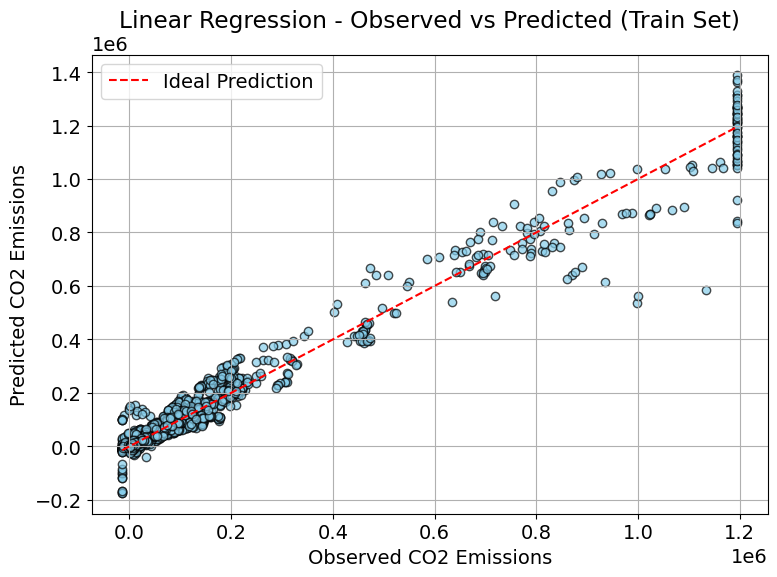

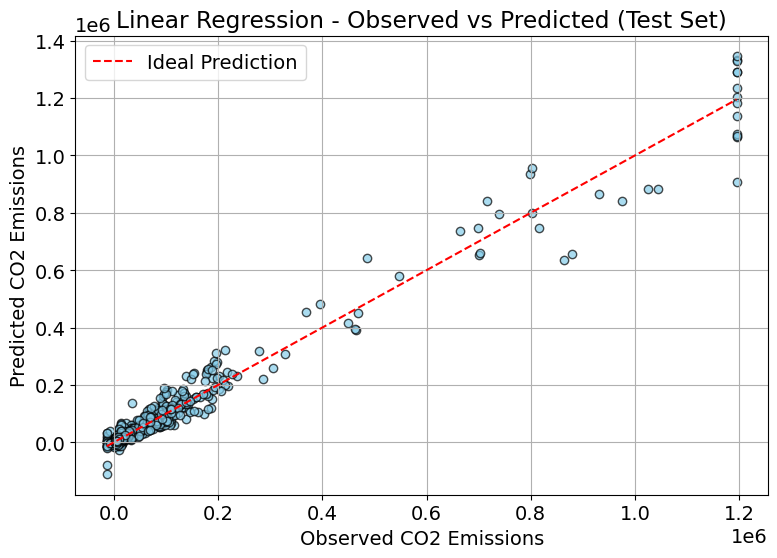

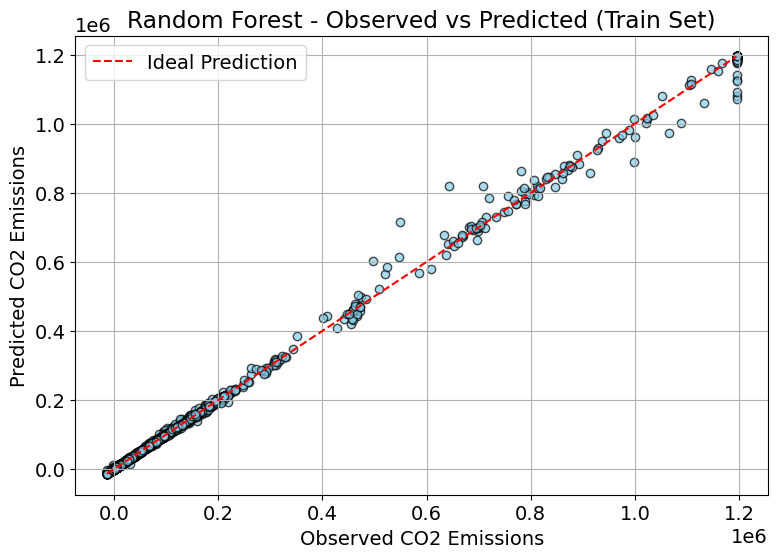

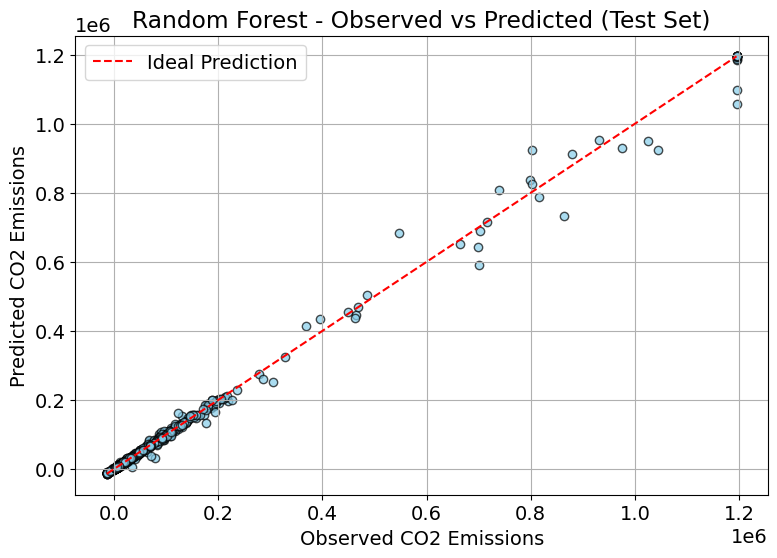

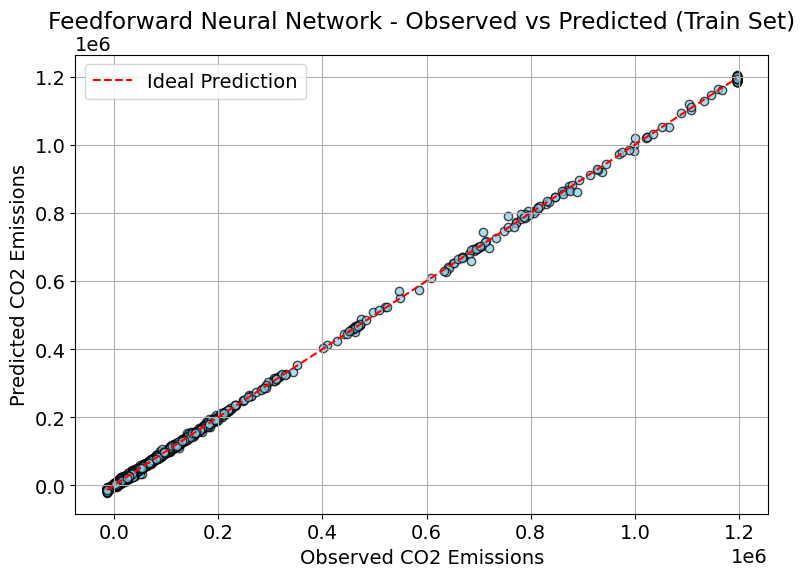

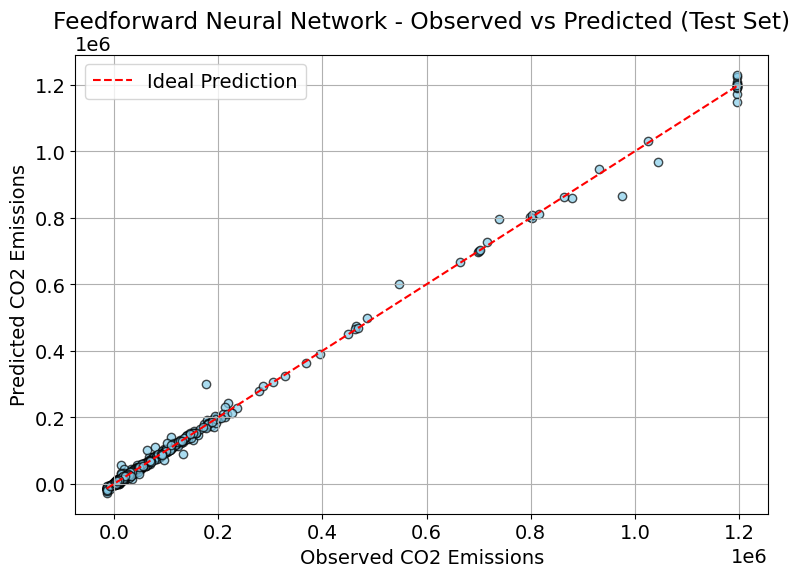

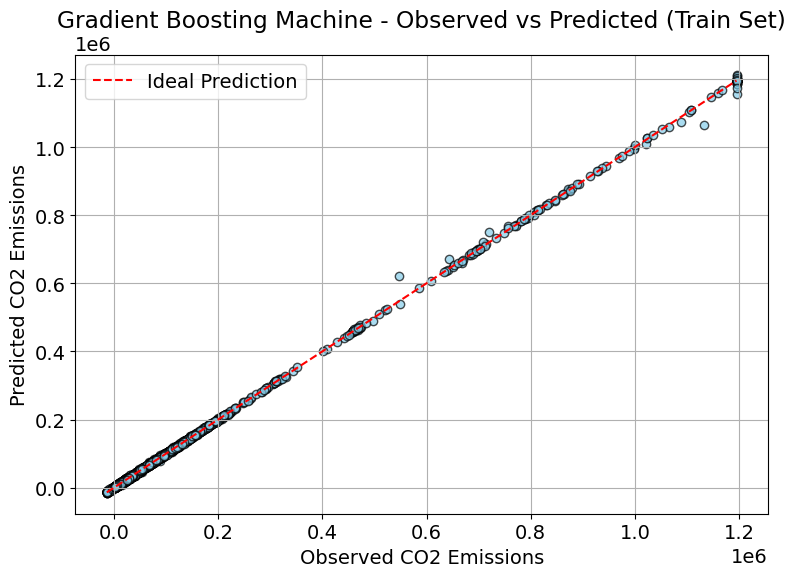

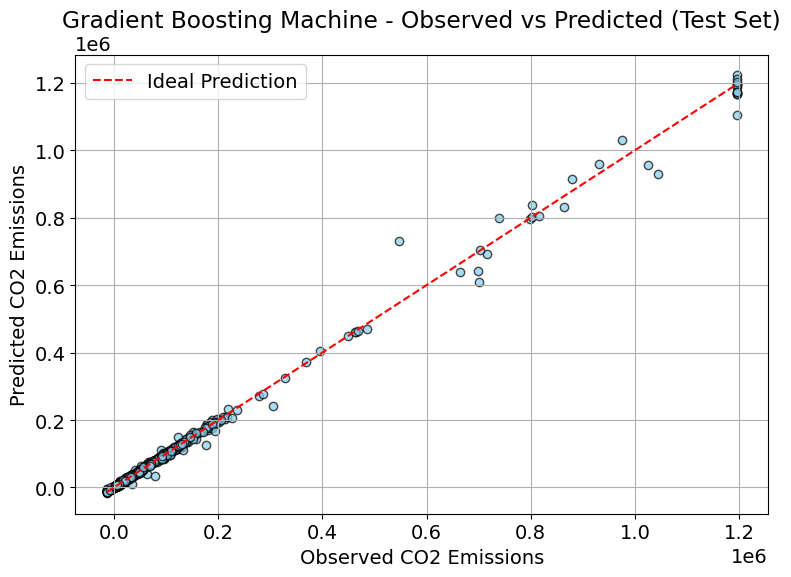

In [122]:
# Error analysis of observed and predicted CO2 emission for training and test data
def plot_scatter_observed_vs_predicted(model_name, y_actual, y_pred, set_type):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_pred, alpha=0.7, color="skyblue", edgecolor="black")
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], color='red', linestyle='--', label="Ideal Prediction")
    plt.xlabel("Observed CO2 Emissions")
    plt.ylabel("Predicted CO2 Emissions")
    plt.title(f"{model_name} - Observed vs Predicted ({set_type} Set)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"{model_name}_Observed_vs_Predicted_{set_type}.png", dpi=300)
    plt.show()

# Generate and save scatterplots for all models
for model_name, model in models.items():
    # Train set predictions
    y_pred_train_scaled = model.predict(x_train_scaled_2)
    y_pred_train = scaler_y_2.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).ravel()
    y_train_original = scaler_y_2.inverse_transform(y_train_scaled_2).ravel()
    plot_scatter_observed_vs_predicted(model_name, y_train_original, y_pred_train, "Train")
    
    # Test set predictions
    y_pred_test_scaled = model.predict(x_test_scaled_2)
    y_pred_test = scaler_y_2.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).ravel()
    y_test_original = scaler_y_2.inverse_transform(y_test_scaled_2).ravel()
    plot_scatter_observed_vs_predicted(model_name, y_test_original, y_pred_test, "Test")

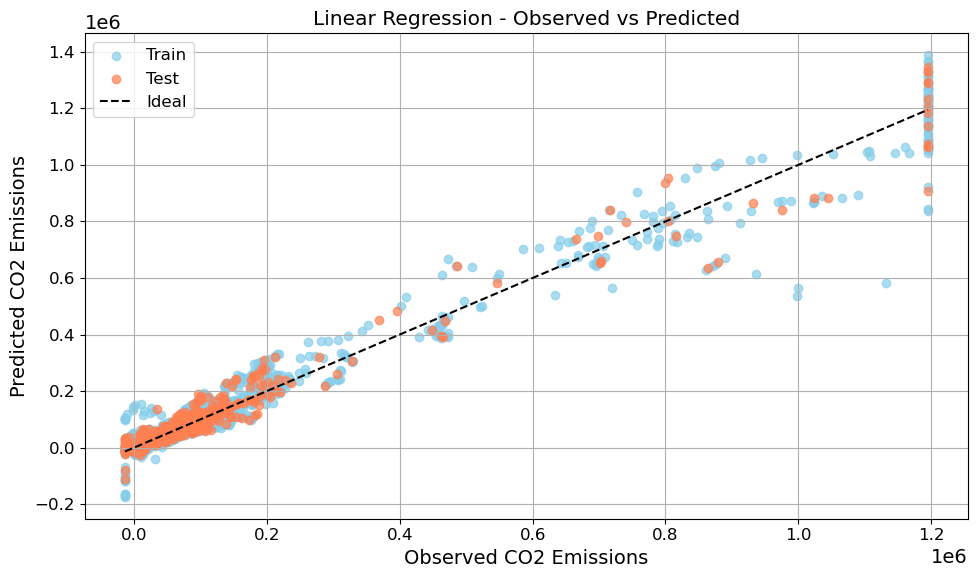

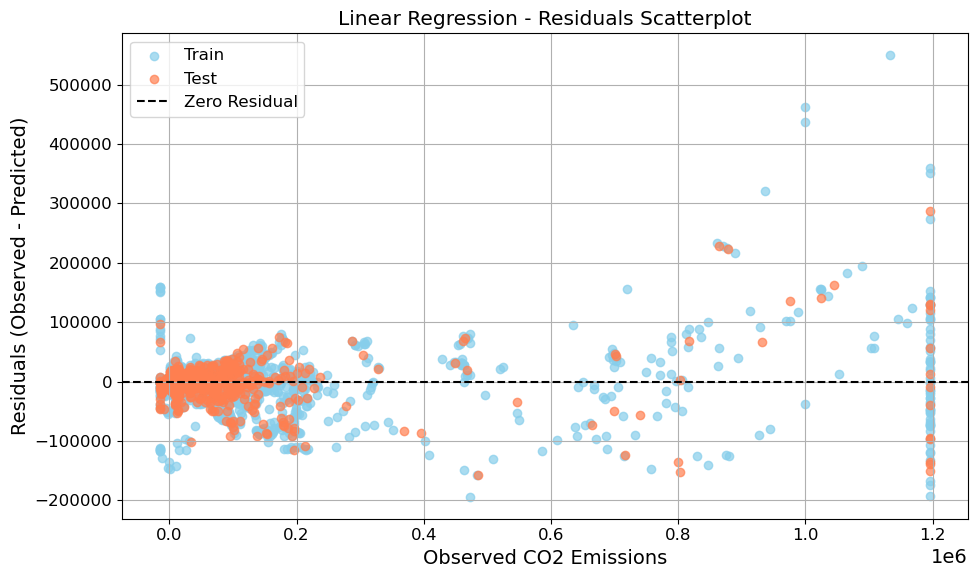

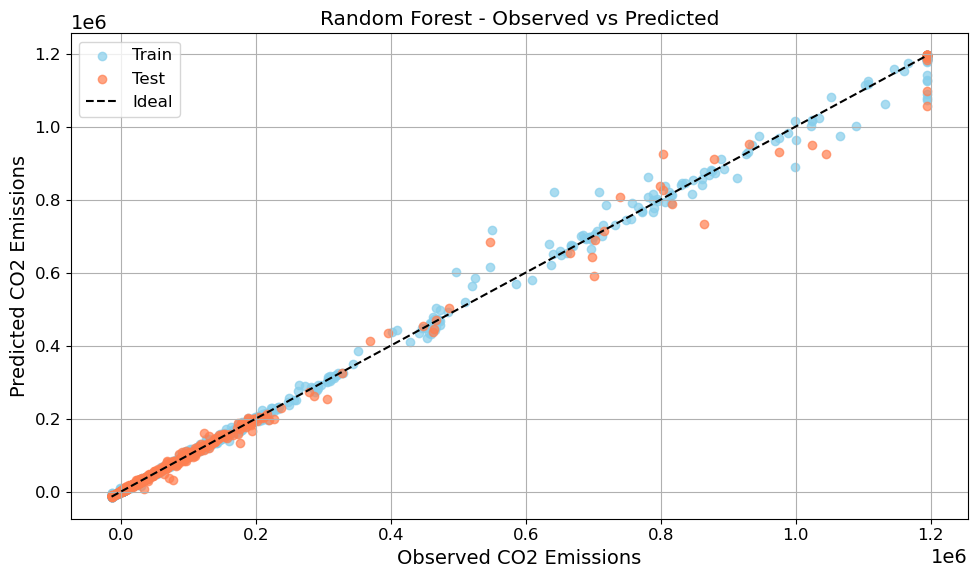

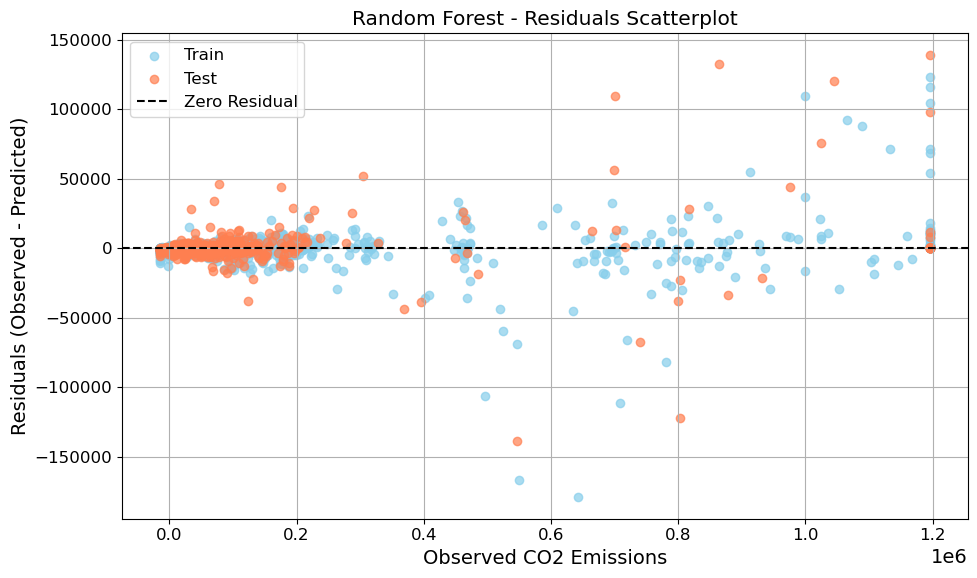

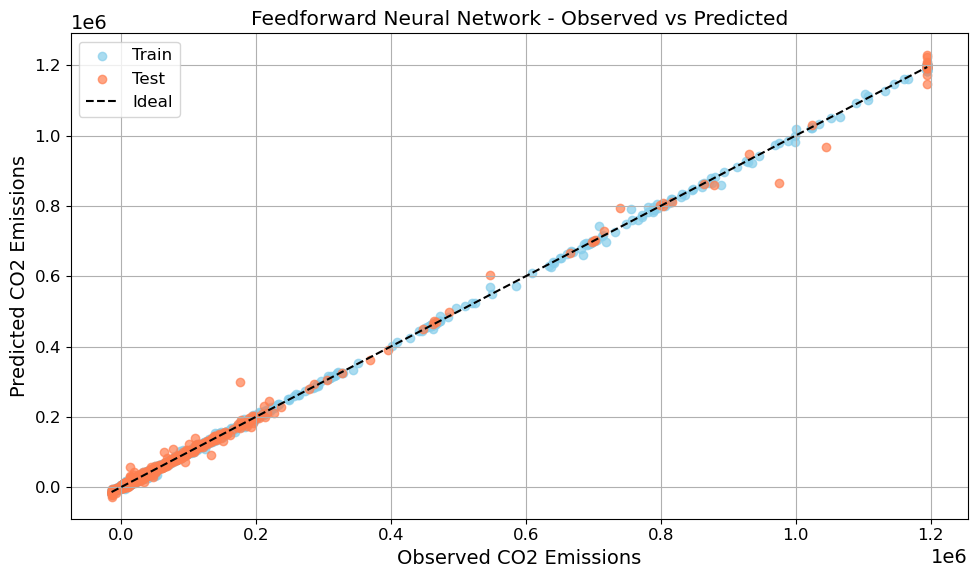

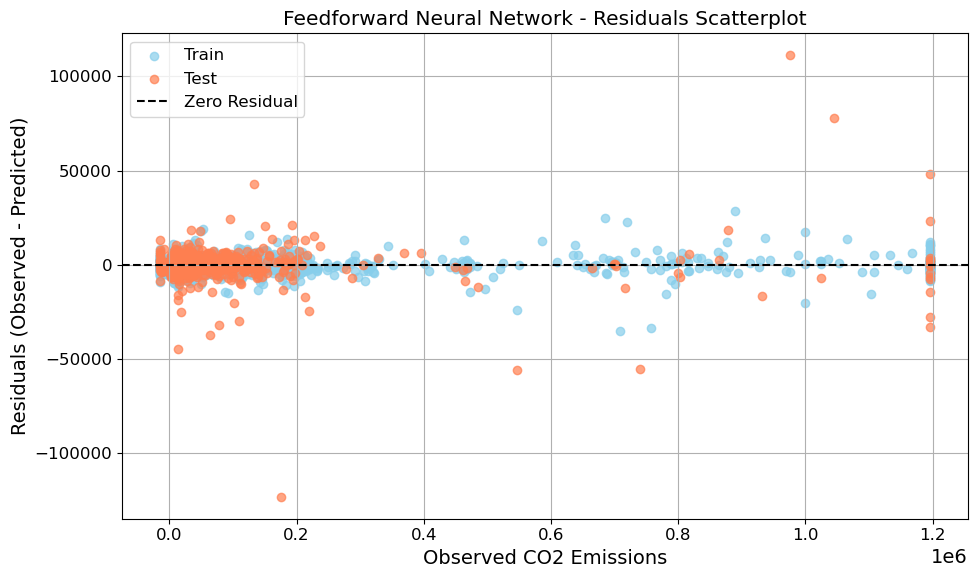

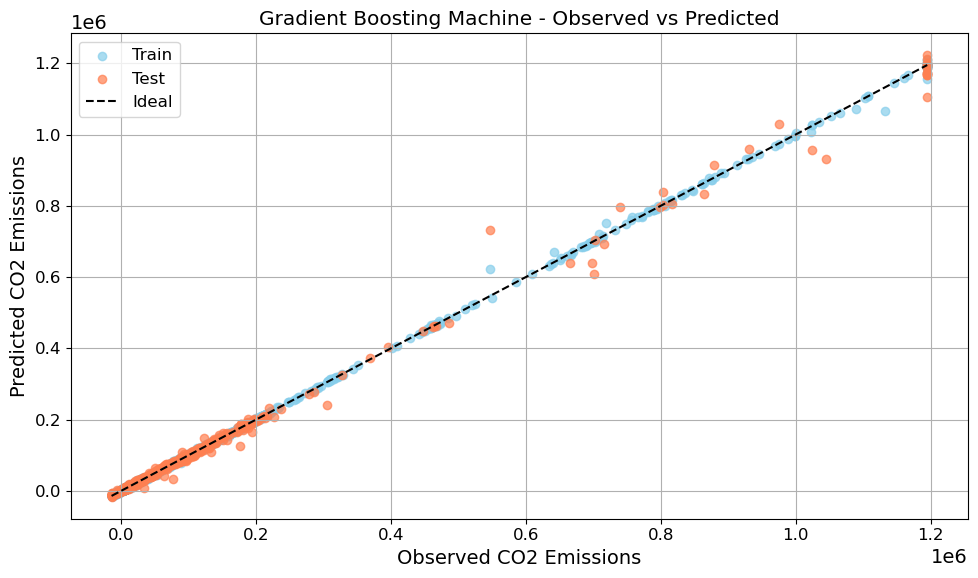

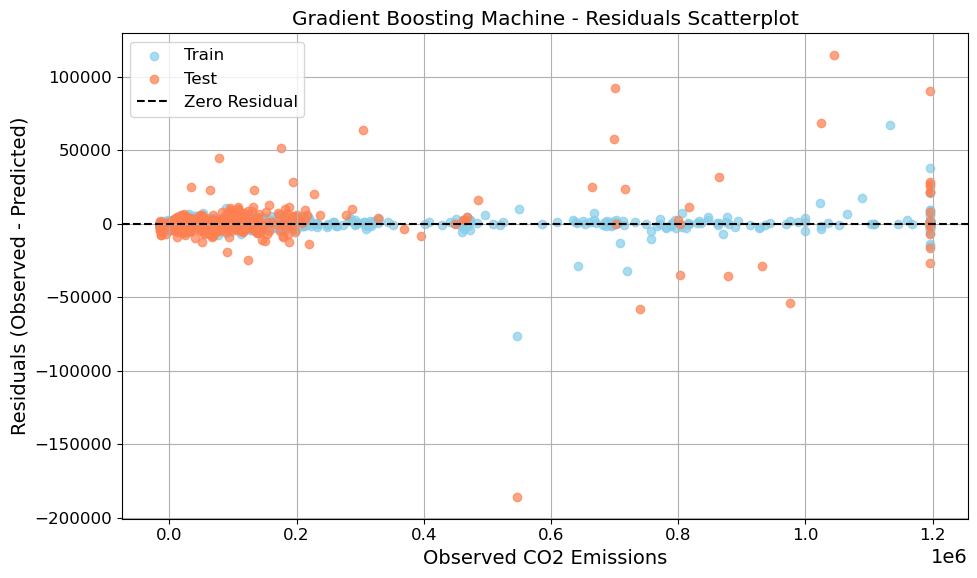


Error Analysis Summary:

Linear Regression:
  Train MSE: 796020204.8950
  Test MSE: 645898649.5665
  Train MAE: 12525.2233
  Test MAE: 11896.7926
  Train R²: 0.9709
  Test R²: 0.9714

Random Forest:
  Train MSE: 42948778.3253
  Test MSE: 109799266.4696
  Train MAE: 1191.9376
  Test MAE: 2372.9781
  Train R²: 0.9984
  Test R²: 0.9951

Feedforward Neural Network:
  Train MSE: 7482437.6796
  Test MSE: 50367225.1736
  Train MAE: 1846.3467
  Test MAE: 2891.0355
  Train R²: 0.9997
  Test R²: 0.9978

Gradient Boosting Machine:
  Train MSE: 4146788.2750
  Test MSE: 77984138.8198
  Train MAE: 841.4927
  Test MAE: 2352.2922
  Train R²: 0.9998
  Test R²: 0.9965


In [123]:
# Perform error analysis for each model
error_analysis = {}
for model_name, model in models.items():
    # Train set predictions
    y_pred_train_scaled = model.predict(x_train_scaled_2)
    y_pred_train = scaler_y_2.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).ravel()
    y_train_original = scaler_y_2.inverse_transform(y_train_scaled_2).ravel()

    # Test set predictions
    y_pred_test_scaled = model.predict(x_test_scaled_2)
    y_pred_test = scaler_y_2.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).ravel()
    y_test_original = scaler_y_2.inverse_transform(y_test_scaled_2).ravel()

    # Compute residuals
    residuals_train = y_train_original - y_pred_train
    residuals_test = y_test_original - y_pred_test

    # Compute error metrics
    mse_train = mean_squared_error(y_train_original, y_pred_train)
    mae_train = mean_absolute_error(y_train_original, y_pred_train)
    r2_train = r2_score(y_train_original, y_pred_train)

    mse_test = mean_squared_error(y_test_original, y_pred_test)
    mae_test = mean_absolute_error(y_test_original, y_pred_test)
    r2_test = r2_score(y_test_original, y_pred_test)

    # Store error metrics in dictionary
    error_analysis[model_name] = {
        "Train MSE": mse_train, "Test MSE": mse_test,
        "Train MAE": mae_train, "Test MAE": mae_test,
        "Train R²": r2_train, "Test R²": r2_test
    }

    # Plot observed vs. predicted for train and test sets
    plt.figure(figsize=(10, 6))
    plt.scatter(y_train_original, y_pred_train, color="skyblue", alpha=0.7, label="Train")
    plt.scatter(y_test_original, y_pred_test, color="coral", alpha=0.7, label="Test")
    plt.plot([y_train_original.min(), y_train_original.max()], [y_train_original.min(), y_train_original.max()], 
             color='black', linestyle='--', label="Ideal")
    plt.xlabel("Observed CO2 Emissions", fontsize=14)
    plt.ylabel("Predicted CO2 Emissions", fontsize=14)
    plt.title(f"{model_name} - Observed vs Predicted", fontsize=14.5)
    plt.legend(fontsize=12)
    plt.grid()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(f"{model_name}_Observed_vs_Predicted.png", dpi=300)
    plt.show()

    # Plot residuals for training and test sets
    plt.figure(figsize=(10, 6))
    plt.scatter(y_train_original, residuals_train, alpha=0.7, color="skyblue", label="Train")
    plt.scatter(y_test_original, residuals_test, alpha=0.7, color="coral", label="Test")
    plt.axhline(0, color='black', linestyle='--', label="Zero Residual")
    plt.xlabel("Observed CO2 Emissions", fontsize=14)
    plt.ylabel("Residuals (Observed - Predicted)", fontsize=14)
    plt.title(f"{model_name} - Residuals Scatterplot", fontsize=14.5)
    plt.legend(fontsize=12)
    plt.grid()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(f"{model_name}_Residuals_Scatterplot.png", dpi=300)
    plt.show()

# Print the summary of error metrics
print("\nError Analysis Summary:")
for model_name, metrics in error_analysis.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")